# Анализ фондового рынка

<b>Задача:</b> Из импортированных файлов  с информацией о динамике цен акций на фондовом рынке необходимо собрать датафрейм, осуществить предобработку, добавить метрики и провести исследовательский анализ цены за последние 3 года. В исследовании использовать скользящие средние, экспотенциальные скользящие средние и RSI индикатор.

<b>Источник данных:</b> https://www.finam.ru/quote/moex/gazp/export/

In [1]:
#загружаем библиотеки 
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV

# 2. Соберите информацию из файлов в единый датафрейм (используйте дополнительные библиотеки).

In [2]:
#прочитаем все файлы из папки с форматом csv
globbed_files = glob.glob('*.csv')

In [3]:
#загрузим все файлы, которые были прочитаны и записаны в globbed_files
dfs = []
for i in globbed_files:
    dfs.append(pd.read_csv(i, sep =';'))
df = pd.concat(dfs, ignore_index=True)
df

<TICKER> <PER>  <DATE>  <TIME>    <OPEN>     <HIGH>     <LOW>    <CLOSE>  \
0        AFLT     D  201201       0  72.02000  72.420000  71.46000  72.180000   
1        AFLT     D  201202       0  72.04000  72.500000  71.70000  72.500000   
2        AFLT     D  201203       0  72.28000  74.320000  72.24000  74.000000   
3        AFLT     D  201204       0  74.18000  75.480000  73.34000  74.140000   
4        AFLT     D  201207       0  74.22000  75.120000  73.60000  74.000000   
...       ...   ...     ...     ...       ...        ...       ...        ...   
4477     VTBR     D  231129       0   0.02415   0.024295   0.02386   0.023900   
4478     VTBR     D  231130       0   0.02389   0.023950   0.02350   0.023885   
4479     VTBR     D  231201       0   0.02387   0.024125   0.02352   0.023610   
4480     VTBR     D  231204       0   0.02359   0.023590   0.02247   0.022545   
4481     VTBR     D  231205       0   0.02266   0.022830   0.02233   0.022520   

             <VOL>  
0         18609590  
1         15799530  
2         34225620  
3         36921900  
4         25660380  
...            ...  
4477   43809670000  
4478   72907910000  
4479   60649830000  
4480  110411120000  
4481   71031210000  

[4482 rows x 9 columns]

Мною для исследования были выбраны 6 акций: Аэрофлот (AFLT), Банкт ВТБ (VTBR), Сбербанк (SBER), Московская биржа (MOEX), ПАО Газпром (GAZP), ПАО Магнит (MGNT) и сделки на фондовом рынке с ними с 1 декабря 2020 года по 5 декабря 2023 года. 

# 3. Осуществите предобработку дат и заголовков.

In [4]:
#изменим названия заголовков на строчный регистр и удалим лишние элементы (<>)
df.columns = ['ticker', 'period', 'date', 'time', 'open', 'high', 'low', 'close', 'vol']
df

ticker period    date  time      open       high       low      close  \
0      AFLT      D  201201     0  72.02000  72.420000  71.46000  72.180000   
1      AFLT      D  201202     0  72.04000  72.500000  71.70000  72.500000   
2      AFLT      D  201203     0  72.28000  74.320000  72.24000  74.000000   
3      AFLT      D  201204     0  74.18000  75.480000  73.34000  74.140000   
4      AFLT      D  201207     0  74.22000  75.120000  73.60000  74.000000   
...     ...    ...     ...   ...       ...        ...       ...        ...   
4477   VTBR      D  231129     0   0.02415   0.024295   0.02386   0.023900   
4478   VTBR      D  231130     0   0.02389   0.023950   0.02350   0.023885   
4479   VTBR      D  231201     0   0.02387   0.024125   0.02352   0.023610   
4480   VTBR      D  231204     0   0.02359   0.023590   0.02247   0.022545   
4481   VTBR      D  231205     0   0.02266   0.022830   0.02233   0.022520   

               vol  
0         18609590  
1         15799530  
2         34225620  
3         36921900  
4         25660380  
...            ...  
4477   43809670000  
4478   72907910000  
4479   60649830000  
4480  110411120000  
4481   71031210000  

[4482 rows x 9 columns]

In [13]:
#проверим на наличие пропусков и посмотрим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4482 entries, 0 to 4481
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  4482 non-null   object 
 1   period  4482 non-null   object 
 2   date    4482 non-null   int64  
 3   time    4482 non-null   int64  
 4   open    4482 non-null   float64
 5   high    4482 non-null   float64
 6   low     4482 non-null   float64
 7   close   4482 non-null   float64
 8   vol     4482 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 315.3+ KB


Я вижу, что столбец с датой имеет формат нечисловой (int64), исправим это. Остальных проблем (пропусков в данных) нет. 

In [6]:
# меняем формат даты 
df['date'] = df['date'].astype('str')
df['date'] = '20' + df['date']
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df

ticker period       date  time      open       high       low      close  \
0      AFLT      D 2020-12-01     0  72.02000  72.420000  71.46000  72.180000   
1      AFLT      D 2020-12-02     0  72.04000  72.500000  71.70000  72.500000   
2      AFLT      D 2020-12-03     0  72.28000  74.320000  72.24000  74.000000   
3      AFLT      D 2020-12-04     0  74.18000  75.480000  73.34000  74.140000   
4      AFLT      D 2020-12-07     0  74.22000  75.120000  73.60000  74.000000   
...     ...    ...        ...   ...       ...        ...       ...        ...   
4477   VTBR      D 2023-11-29     0   0.02415   0.024295   0.02386   0.023900   
4478   VTBR      D 2023-11-30     0   0.02389   0.023950   0.02350   0.023885   
4479   VTBR      D 2023-12-01     0   0.02387   0.024125   0.02352   0.023610   
4480   VTBR      D 2023-12-04     0   0.02359   0.023590   0.02247   0.022545   
4481   VTBR      D 2023-12-05     0   0.02266   0.022830   0.02233   0.022520   

               vol  
0         18609590  
1         15799530  
2         34225620  
3         36921900  
4         25660380  
...            ...  
4477   43809670000  
4478   72907910000  
4479   60649830000  
4480  110411120000  
4481   71031210000  

[4482 rows x 9 columns]

In [7]:
#зададим размер графиков
plt.rcParams['figure.figsize'] = (12, 4)

In [8]:
#установим тему для графиков
sns.set_theme(style="whitegrid", palette='dark:salmon_r')

# 4. Постройте линейные графики динамики цены для каждой акции (реализуйте в цикле). 

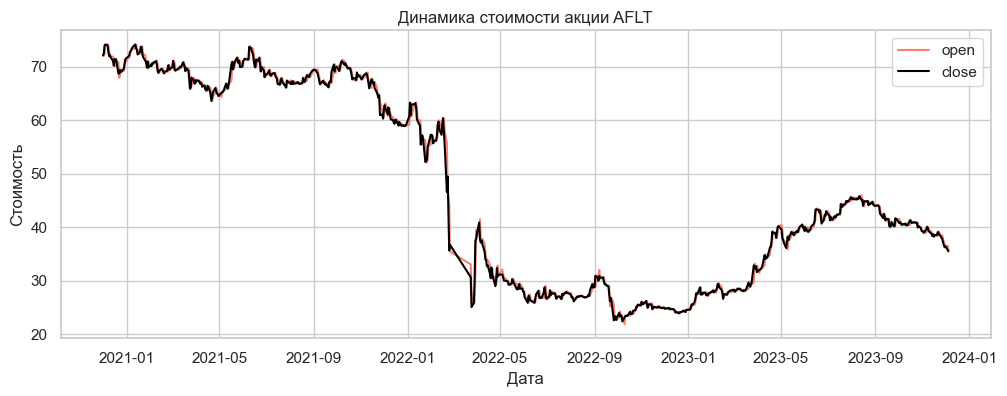

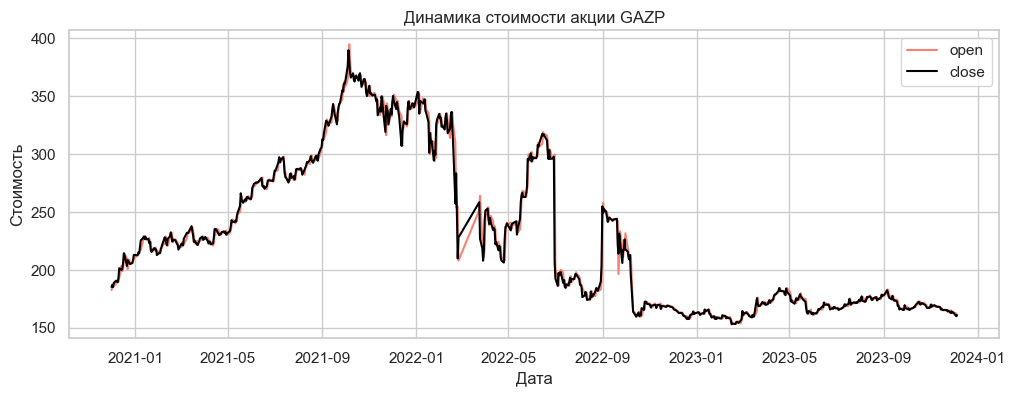

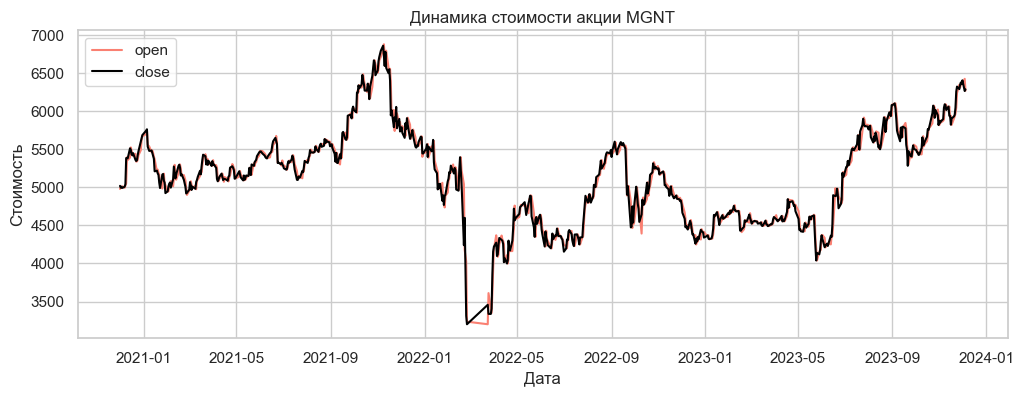

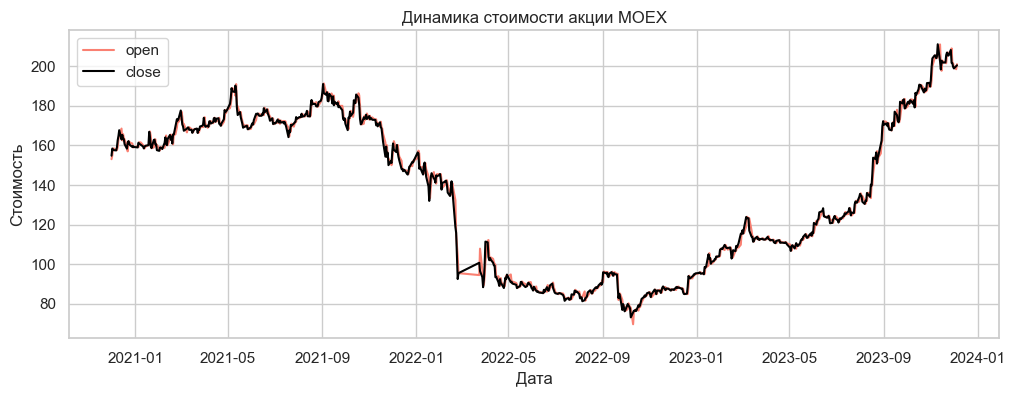

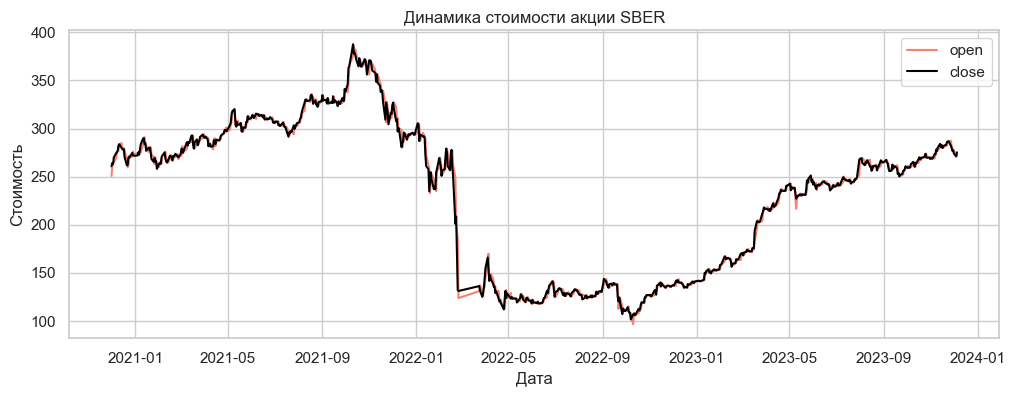

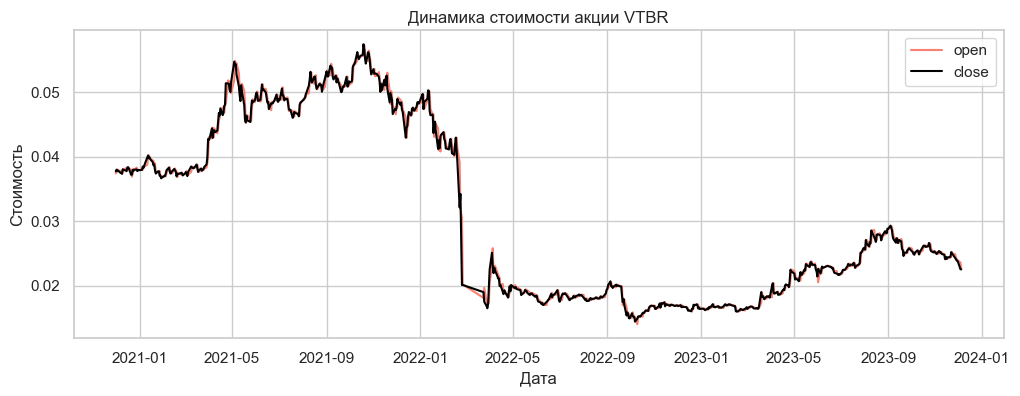

In [9]:
list_1 = list(df['ticker'].unique())
for i in list_1:
    a = sns.lineplot(data=df[df['ticker'] == i], x='date', y='open').set(title=f'Динамика стоимости акции {i}', xlabel='Дата', ylabel='Стоимость')
    b = sns.lineplot(data=df[df['ticker'] == i], x='date', y='close', color='black')
    plt.legend(['open', 'close'])
    plt.show(a, b)

На этих графиках я соединила цены закрытия и открытия, чтобы более точно увидеть, что в общем и целом на таком большом масштабе колебания цены за день не очень-то и заметны, поэтому мы просто можем видеть скачкообразную динамику с очевидным проседанием рынка после февраля 2022 по всем акциям. <br>

Аэрофлот (AFLT) <br>
В начале 2022 компания продемонстрировала впечатляющее улучшение финансовых показателей, отразившееся на динамике ее акций, однако февральский обвал не прошел мимо этой авикомпании. Однако, к маю мы видим резкий скачок в рост и к 2023 году относительно стабильную положительную динамику, которая, по словам аналитиков, должна сохраняться. Причинами такого роста считают восстановление международных авиаперевозок путем возрождения туристического сектора, а также операционная эффективность, которая позволит сократить расходы и увеличить прибыльность, что повысит цены акций и доверие инвесторов. <br>

Газпром (GAZP) <br>
В 2021 году можно видеть хороший рост стоимости акций, который обрубается февралем 2022 года вместе с дальнейшими проблемами с Северным потоком и падением акций после совета директоров в июле 2022. В 2023 году акции очень медленно отрастают в связи с сложной ситуацией, которая наклаывает множество влияющих факторов: потеря прибыльного европейского рынка, увеличение налоговой нагрузки, а также рост капитальных затрат, тренд на снижение добычи газа По прогнозам аналитиков, в 2023 году акции «Газпрома» смогут частично компенсировать потери этого года, которые составили более 50%. Однако роста бумаг «Газпрома» до новых максимумов в следующем году никто из экспертов не ожидает. <br>

Магнит (MGNT) <br>
Бумаги эмитента были под давлением с конца прошлого года из-за сокращения прозрачности бизнеса и понижения уровня листинга на Мосбирже из-за отсутствия действующего совета директоров. При этом фундаментально бизнес выглядит устойчиво, бумаги ретейлера интересны и, по оценке аналитиков, имеют возможность роста на 19% за ближайший год. <br>

Сбербанк (SBER) <br>
В марте 2023 года стоимость акции  удвоилась в цене после объявления о выплате рекордных дивидендов. В целом в 2023 году наблюдается рост, а в конце года стоимость акций превысила максимумы прошлого года благодаря рекордным показателям прибыли за и модернизированию дивидендной политики. <br>

<br>





Как было сказано выше, по всему периоду не видно колебаний цены за день, что часто бывает очень важно для анализа ситации на фондовом рынке, поэтом причнами для динамики цен используют свечные графики, которые окрашиваются в красный (цена закрытия ниже цены открытия) или зеленый цвет (цена закрытия ниже цены открытия), длина свечи как раз представляет собой разность между ценой открытия и ценой закрытия. Также у свечей есть усы ( максимальная и минимальная цены за день). График таких свечей построен ниже.


In [10]:
import plotly.graph_objects as go
list_1 = list(df['ticker'].unique())
for i in list_1:
    fig = go.Figure(data=[go.Candlestick(x=df[df['ticker'] == i]['date'], open=df[df['ticker'] == i]['open'], high=df[df['ticker'] == i]['high'], low=df[df['ticker'] == i]['low'], close=df[df['ticker'] == i]['close'])])
    fig.update_layout(
    title_text=f'Динамика стоимости акции {i}',
    xaxis_title='Дата',
    yaxis_title='Стоимость')
    fig.show()

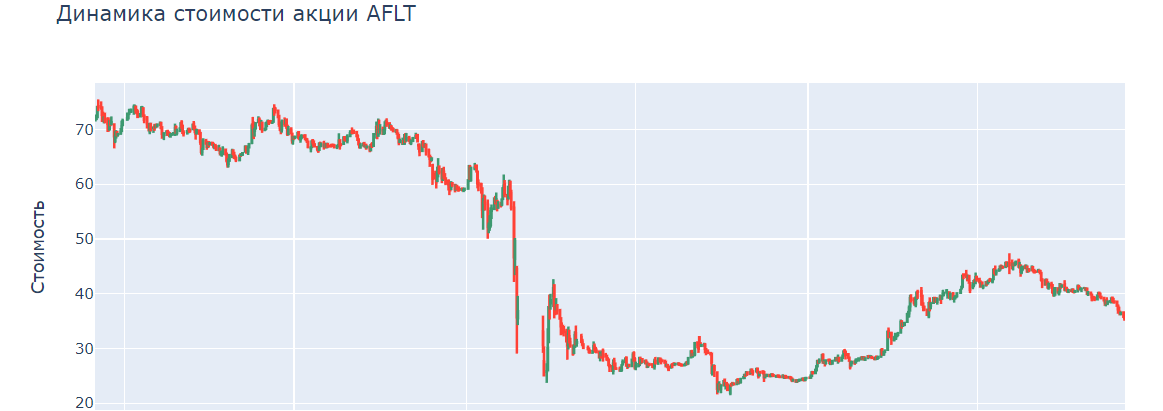

Как мы можем увидеть, все акций, выбранные мною для исследования, за весь рассматриваемый период имеет скачкообразную динамику. Особенно яркой тенденцией для всех них можно считать проседание стоимости в феврале 2022 года на фоне всем известных событий. Однако, после такого резкого падения для всех шести ценных бумаг мы можем видеть возрождение и постепенный рост их стоимости (кроме Газпрома). Акциям Магнита (MGNT) и Московской биржи (MOEX) даже удалось зафиксировать рост, который превысил дообвальные значения. 

# 5. Для каждой акции найдите дни максимального изменения цены (взлета и падения). Составьте отчет. 

In [10]:
#измерим волатильность - изменчивость цены за день.
df['volatility'] = df['close']-df['open']

In [11]:
#найдем максимальное отклонение цены
list_1 = list(df['ticker'].unique())
df_1 = pd.DataFrame()
for i in list_1:
    report = df[df['ticker'] == i].pivot_table(index='date', aggfunc='max', values='volatility').reset_index()
    report.columns = ['date','max']
    report = report.sort_values (by = ['max'], ascending=False).head(1)  
    report['ticker'] = i
    df_1 = df_1.append(report,ignore_index=True)

C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\352704662.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_1 = df_1.append(report,ignore_index=True)
C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\352704662.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_1 = df_1.append(report,ignore_index=True)
C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\352704662.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_1 = df_1.append(report,ignore_index=True)
C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\352704662.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_1 = df_1.append(report,ignore_index=True)
C:\Users\Настя\A

In [12]:
#найдем минимальное отклонение цены
list_1 = list(df['ticker'].unique())
df_2 = pd.DataFrame()
for i in list_1:
    report = df[df['ticker'] == i].pivot_table(index='date', aggfunc='min', values='volatility').reset_index()
    report.columns = ['date','min']
    report = report.sort_values (by = ['min'], ascending=True).head(1)  
    report['ticker'] = i
    df_2 = df_2.append(report,ignore_index=True)

C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\3516617622.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2 = df_2.append(report,ignore_index=True)
C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\3516617622.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2 = df_2.append(report,ignore_index=True)
C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\3516617622.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2 = df_2.append(report,ignore_index=True)
C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\3516617622.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2 = df_2.append(report,ignore_index=True)
C:\Users\Нас

In [13]:
df_1.merge(df_2, on='ticker', how='right')

date_x       max ticker     date_y        min
0 2022-03-30    6.3600   AFLT 2022-02-21   -9.16000
1 2022-02-22   29.5600   GAZP 2022-06-30  -92.60000
2 2022-02-22  420.0000   MGNT 2022-02-21 -801.00000
3 2022-04-01   10.1800   MOEX 2022-02-21  -13.63000
4 2021-11-23   20.5600   SBER 2022-02-24  -54.40000
5 2021-04-23    0.0032   VTBR 2022-02-24   -0.01041

Посмотрим на дни максимального падения стоимости акций: <br>

21 февраля 2022 года для Аэрофлота (AFLT) (-9,16), Магнита (MGNT) (-801), Московской биржи (MOEX) (-13,63) <br>
24 февраля 2022 года для Сбербанка (SBER) (-54,4), Банка ВТБ (VTBR) (-0,01) <br>
30 июня 2022 года для Газпрома (GAZP) (-92,6) это можно связать с рекомендацией совета директоров компании не выплачивать дивиденды по итогам второй половины 2022 года после заседания.  <br>

Посмотрим на дни максимального роста стоимости акций: <br>

23 апреля 2021 года для Банка ВТБ (VTBR) (0,0032) <br>
23 ноября 2021 года для Сбербанка (SBER) (20,56) <br>
22 февраял 2022 года для Газпрома (GAZP) (29,46), Магнита (MGNT) (420) <br>
30 марта 2022 года для Аэрофлота (AFLT) (6,3) <br>
1 апреля 2022 года для Московской биржи (MOEX) (10,18) <br>

# 6. Найдите скользящие средние (периоды 10, 50, 100) для каждой акции. Добавьте на график.

In [14]:
#считаем скользящие средние с периодом 10
a = []
sm = []
list_1 = list(df['ticker'].unique())
for i in list_1:
    k = df[df['ticker'] == i]['close'].rolling(window=10).mean().fillna(0)
    a.append(k)
for i in range(len(a)):
    sm += list(a[i])
df['SMA_10'] = sm 

In [15]:
#считаем скользящие средние с периодом 50
a = []
sm = []
list_1 = list(df['ticker'].unique())
for i in list_1:
    k = df[df['ticker'] == i]['close'].rolling(window=50).mean().fillna(0)
    a.append(k)
for i in range(len(a)):
    sm += list(a[i])
df['SMA_50'] = sm 

In [16]:
#считаем скользящие средние с периодом 100
a = []
sm = []
list_1 = list(df['ticker'].unique())
for i in list_1:
    k = df[df['ticker'] == i]['close'].rolling(window=100).mean().fillna(0)
    a.append(k)
for i in range(len(a)):
    sm += list(a[i])
df['SMA_100'] = sm 

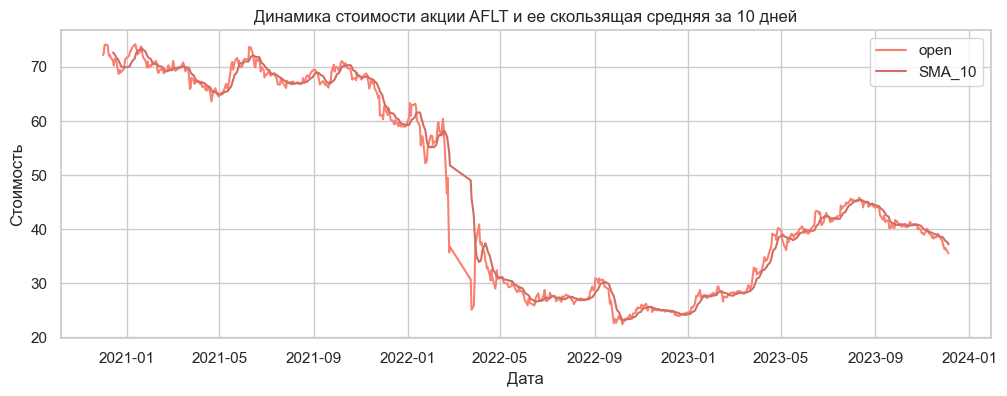

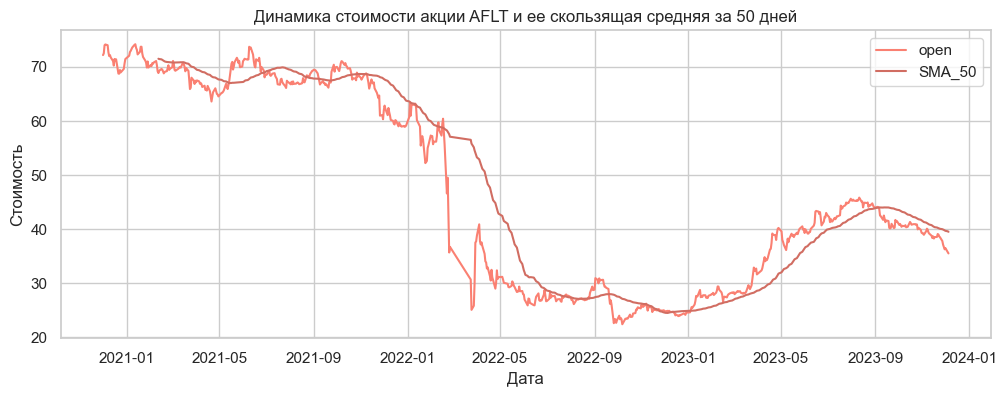

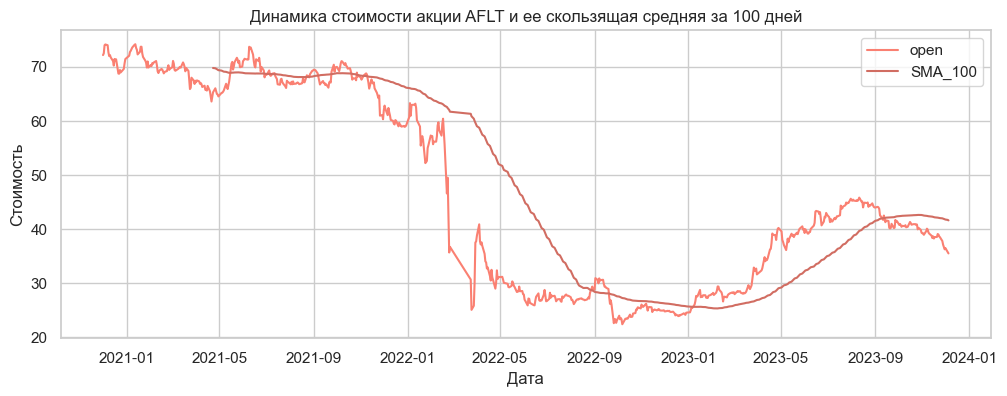

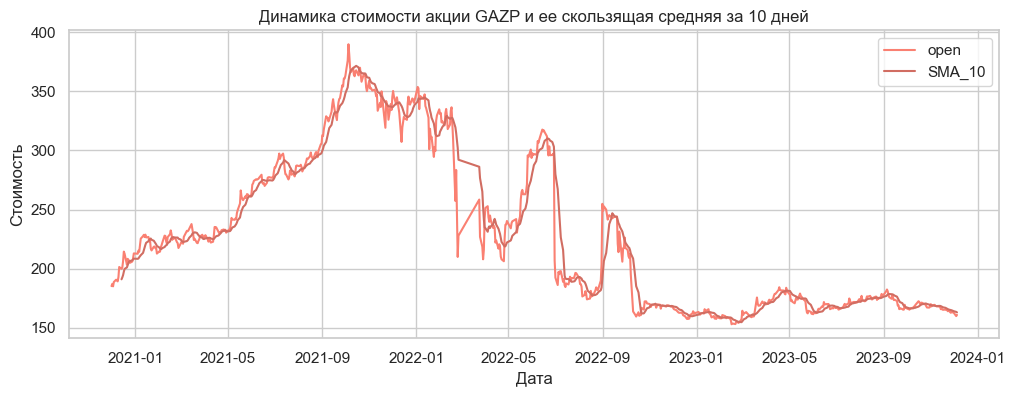

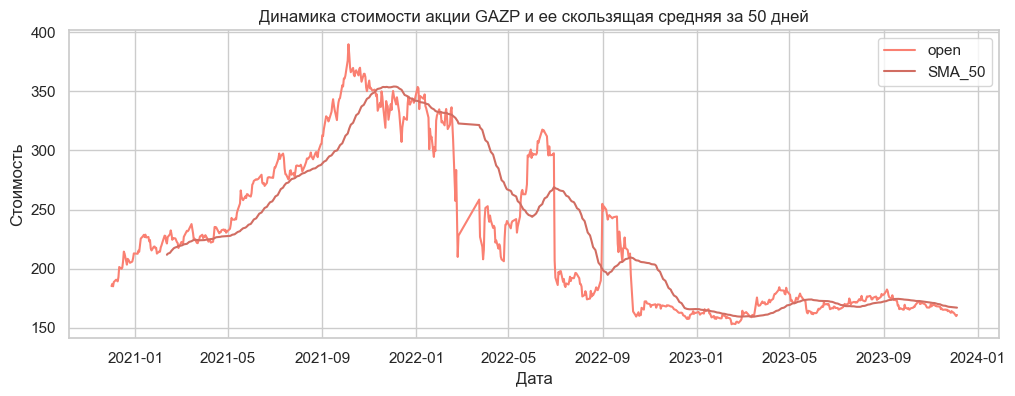

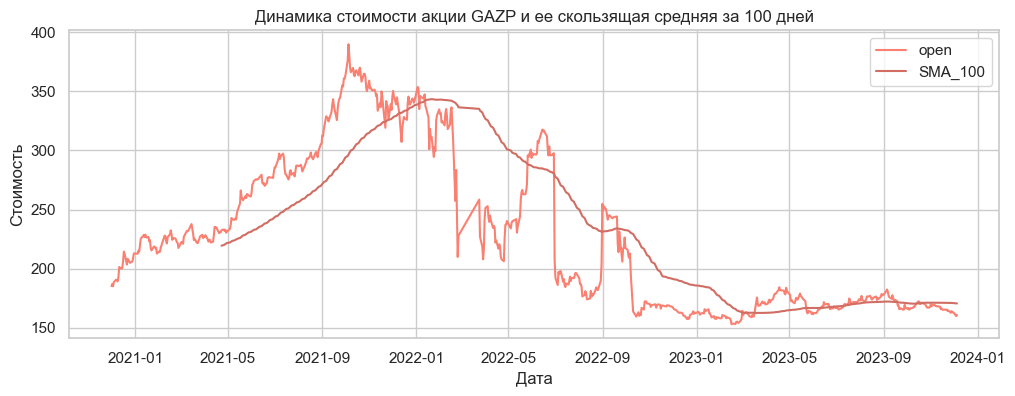

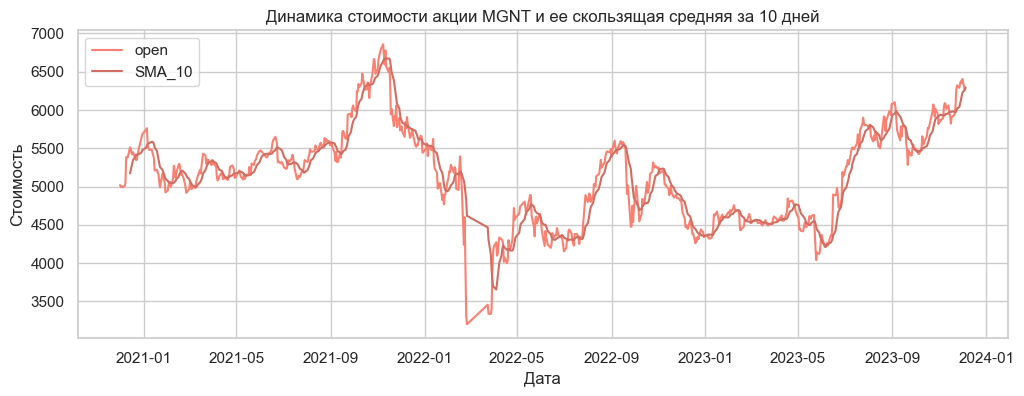

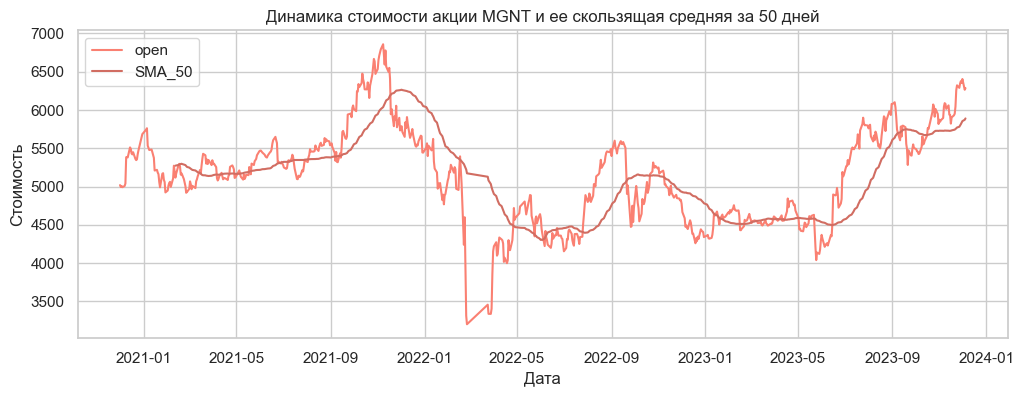

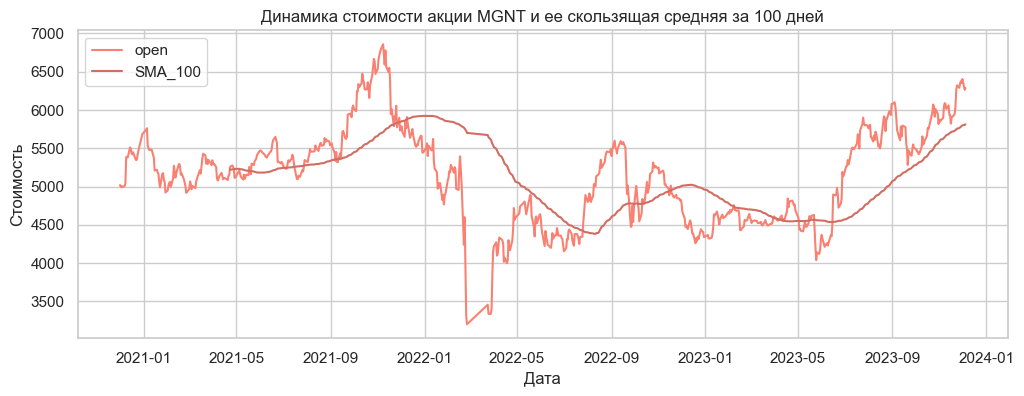

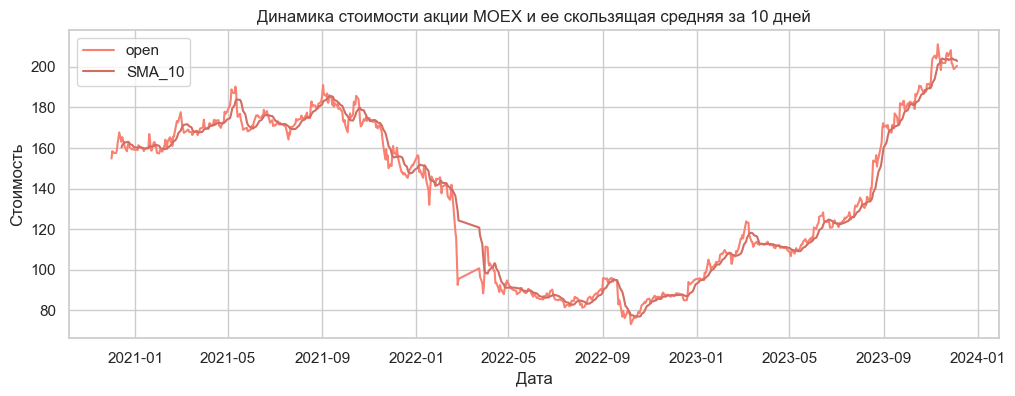

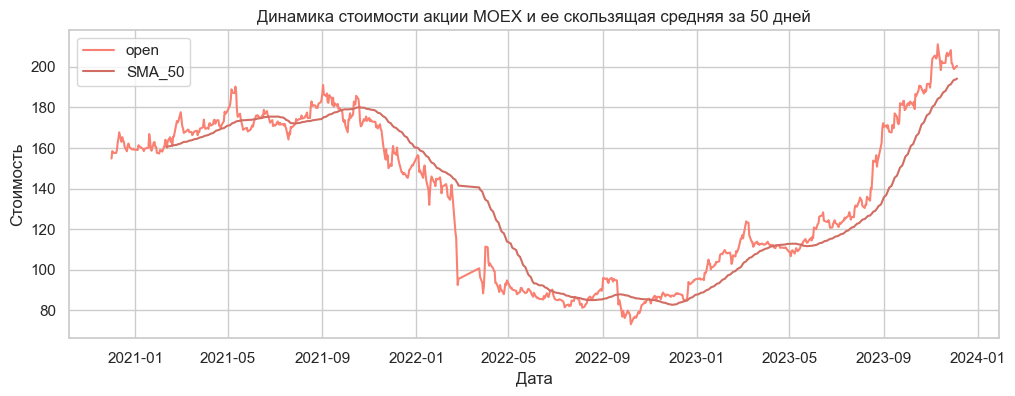

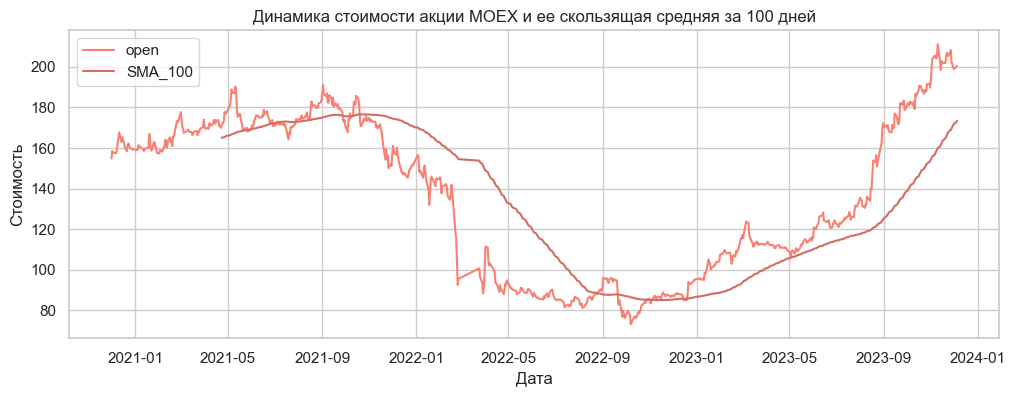

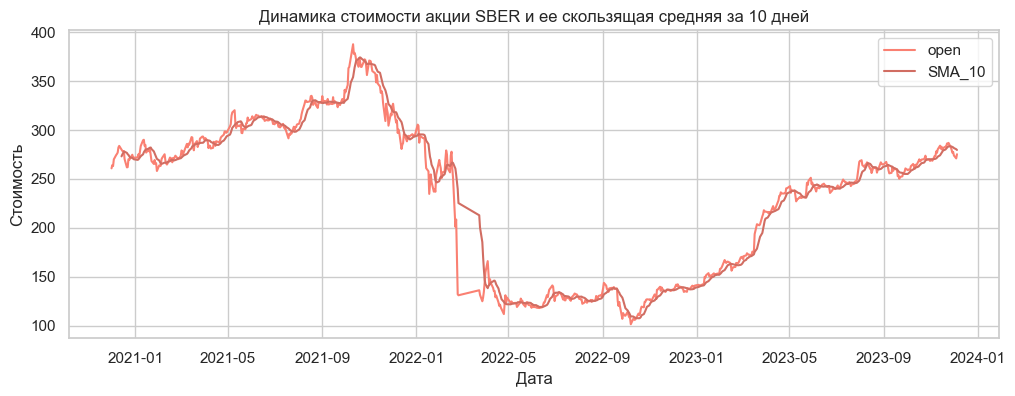

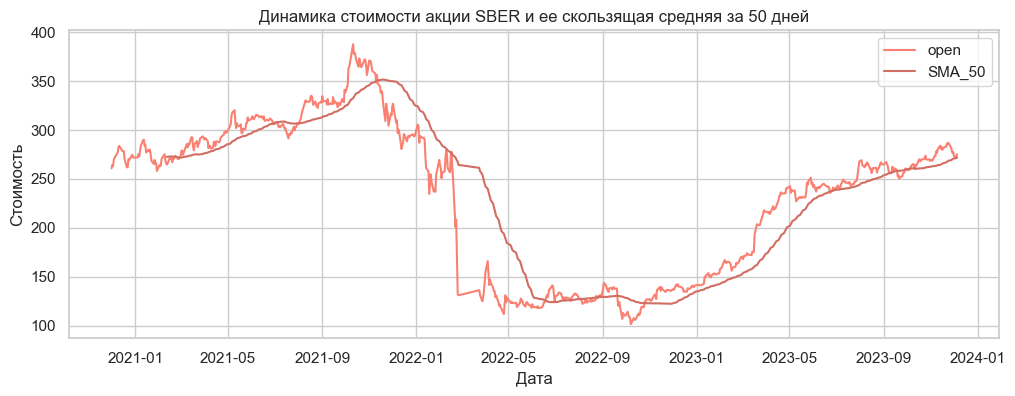

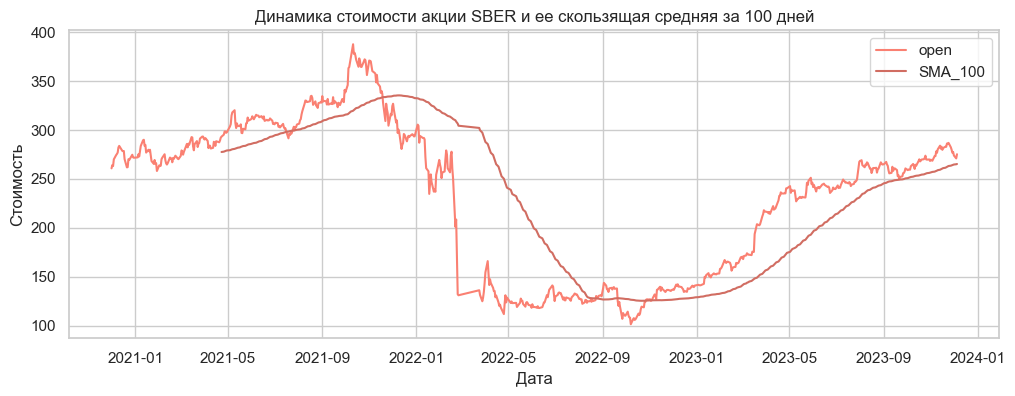

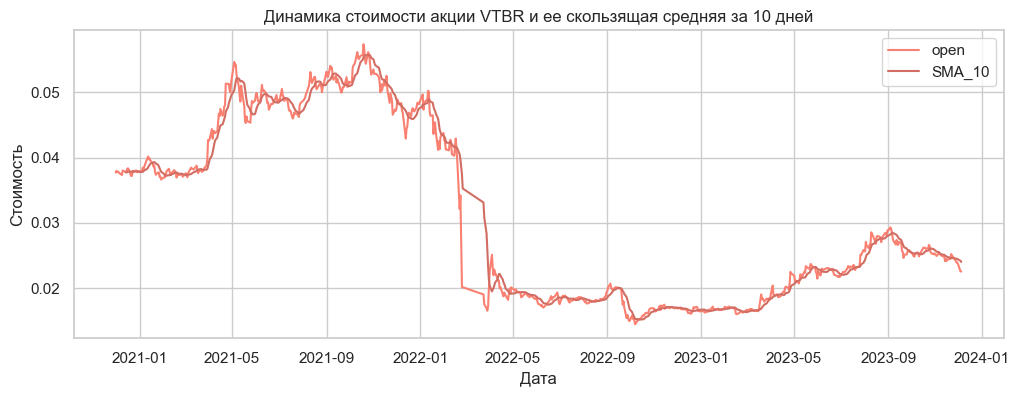

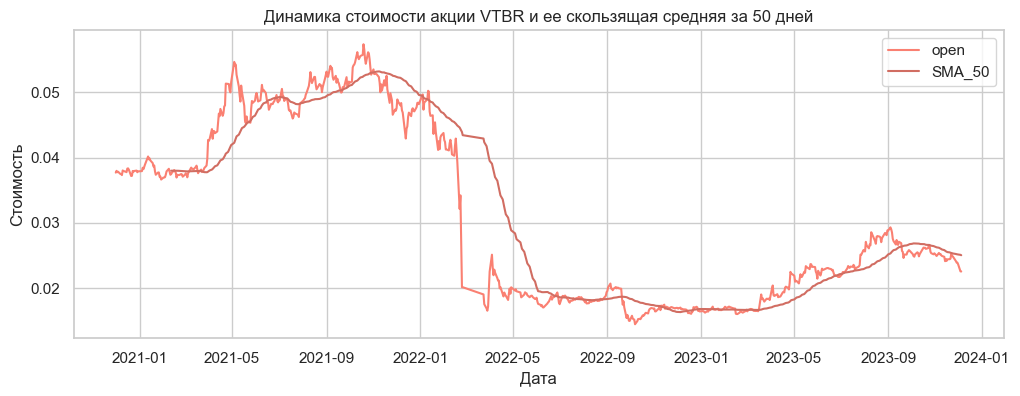

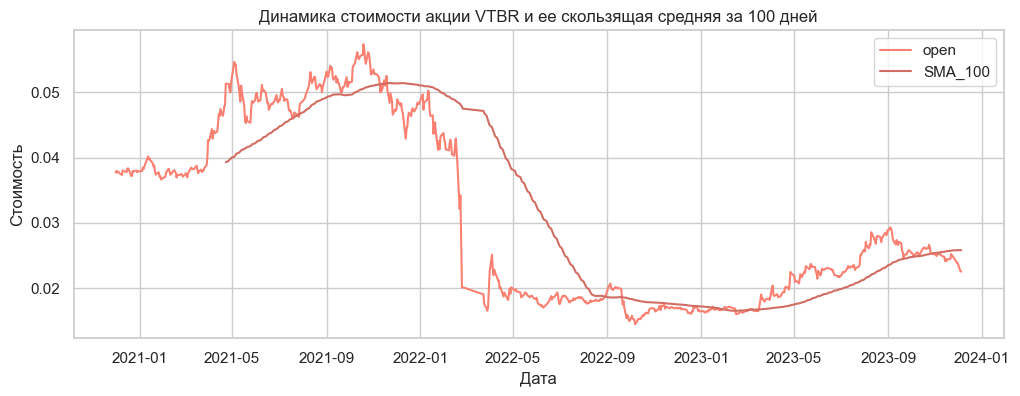

In [17]:
list_1 = list(df['ticker'].unique())
for j, i in enumerate(list_1):
   
    a = sns.lineplot(data=df[df['ticker'] == i], x='date', y='close').set(title=f'Динамика стоимости акции {i} и ее скользящая средняя за 10 дней', xlabel='Дата', ylabel='Стоимость')
    b = sns.lineplot(data=df[(df['ticker'] == i) & (df['SMA_10'] != 0)], x='date', y='SMA_10')
    plt.legend(['open', 'SMA_10'])
    plt.show()
    
    f = sns.lineplot(data=df[df['ticker'] == i], x='date', y='close').set(title=f'Динамика стоимости акции {i} и ее скользящая средняя за 50 дней', xlabel='Дата', ylabel='Стоимость')
    k = sns.lineplot(data=df[(df['ticker'] == i) & (df['SMA_50'] != 0)], x='date', y='SMA_50')
    plt.legend(['open', 'SMA_50'])
    plt.show()
    
    l = sns.lineplot(data=df[df['ticker'] == i], x='date', y='close').set(title=f'Динамика стоимости акции {i} и ее скользящая средняя за 100 дней', xlabel='Дата', ylabel='Стоимость')
    m = sns.lineplot(data=df[(df['ticker'] == i) & (df['SMA_100'] != 0)], x='date', y='SMA_100')
    plt.legend(['open', 'SMA_100'])
    plt.show()

Скользящая средняя хоть легко и понятно реализуется, но имеет ряд недстатков: <br>
− все значения входят с одинаковым весом; <br>
− двойное реагирование на слагаемое; <br>
− в первой точке и последней точке нельзя рассчитать сглаженные значения. <br>

Эти недостатки особенно хорошо заметны при сглживании уже 50 дней,так как на рынке существуют мелкие существенные колебания, которые уже не отражаютя на графике из-за сглаживания. Десятидневное сглаживание в целом неплохо показывает себя на графике динамики стоимости всеэ акций, а вот 50 дневное и стодневное, тем более, значительно устраняют колебания, оставляя лишь общую динамику стоимости за исследуемый период, причем с запозданием (что может быть полезно при прогнозе на будущие периоды). <br>

Но, если исследователю важна лишь общая тенденция, то есть уровень тренда динамики стоимости акций, которяа преобладает на рынке, то скользящая средняя с периодом сглаживания в 100 (50) дней довольно неплохо все это показвает в общих чертах. <br>
Если цена на графике динамики выше средней сглаженной, то это значит, что акции перекупаются, то есть покупателей больше, чем продавцов (нужно продавать), а если ниже, наоборт, акции в зоне, где продавцов больше, чем покупателей (нужно покупать). 

# 7. Постройте в цикле графики объема (volume) для каждого тикера.

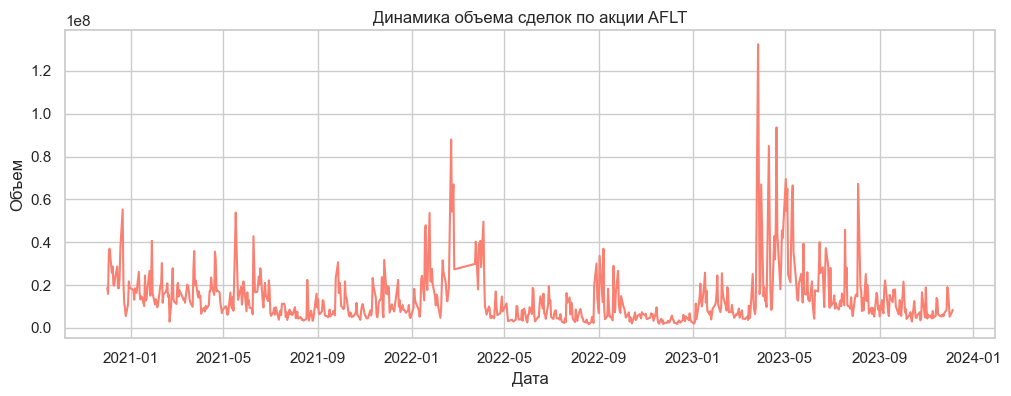

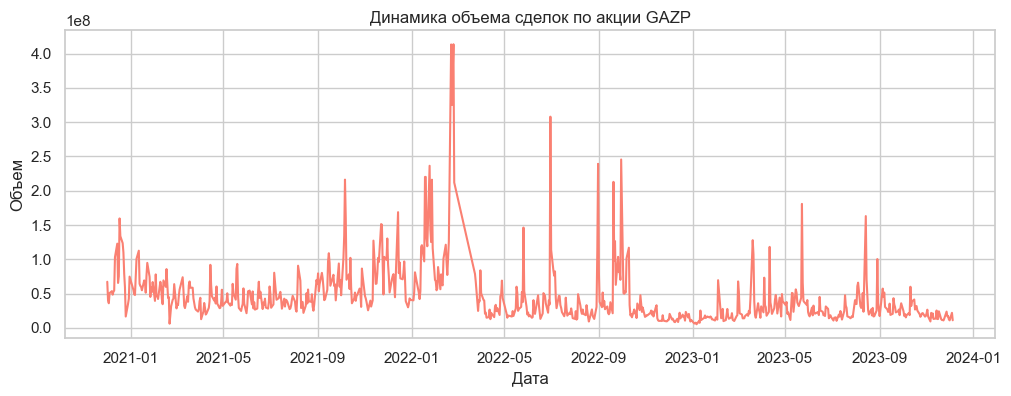

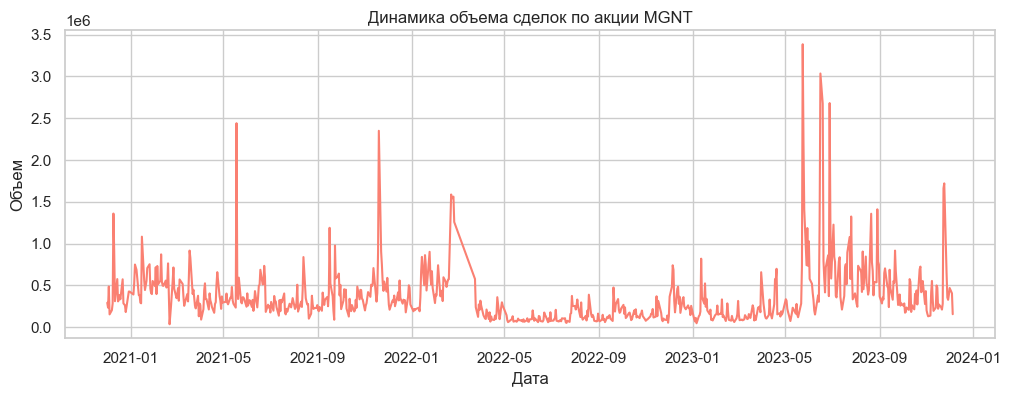

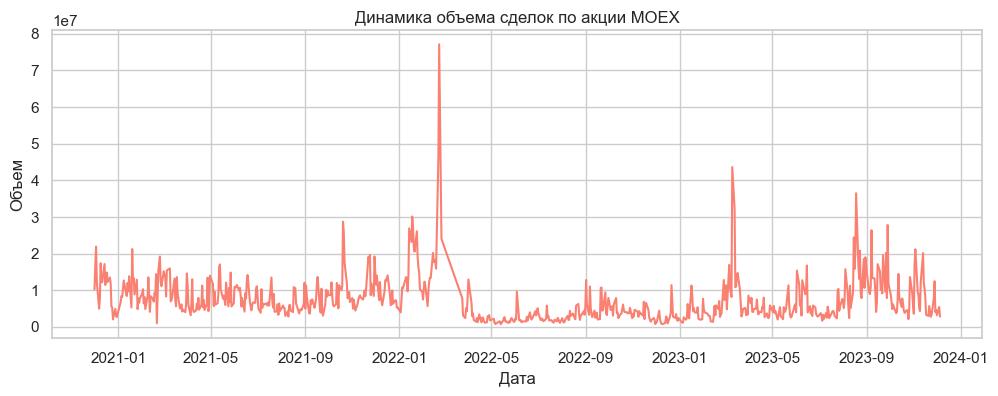

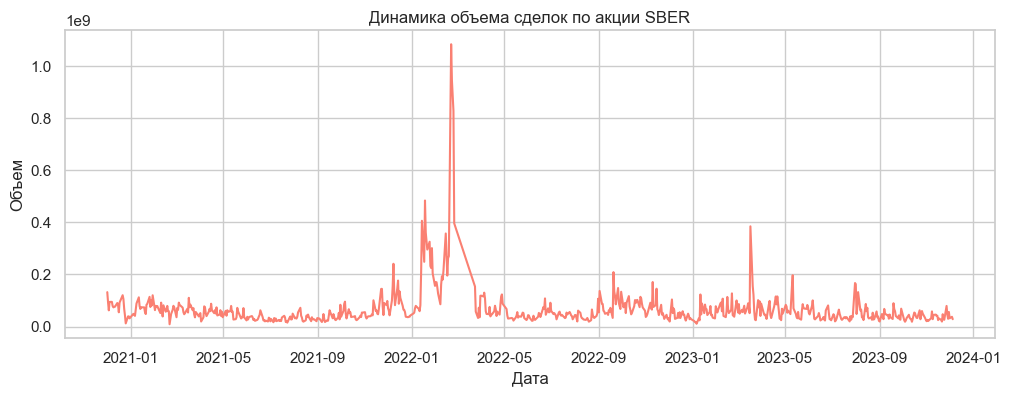

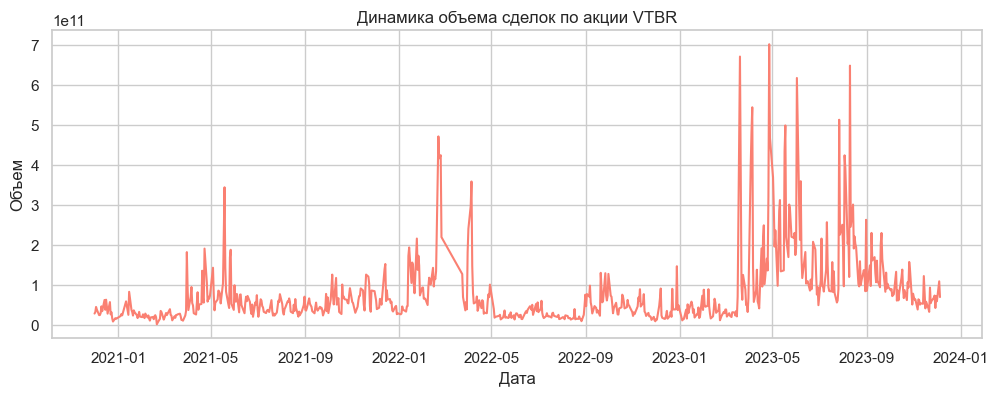

In [19]:
list_1 = list(df['ticker'].unique())
for i in list_1:
    sns.lineplot(data=df[df['ticker'] == i], x='date', y='vol').set(title=f'Динамика объема сделок по акции {i}',
                                                                 xlabel='Дата', 
                                                                 ylabel='Объем')
    plt.show()

Каждая акция, очевидно, имеет собственные тенденции в объемах торгов (сезонность, выход отчетности, заседание совета директоров и т.д.), однако общим для всех шести котировок можно считать всплеск активности в феврале - марте 2022 года, когда произошел обвал российского рынка бумаг на фоне последних гео-политических событий, это можно объяснить тем, что часть инвестров желала срочно избавиться от дещевеющих на глазах активах, а другая часть инвесторов активно их скупала, тем самым эти действия образовывали огромный оборт акцией за один торговый день на бирже. <br>


# 8. Реализуйте в цикле для каждого тикера последовательно: график цены вместе с скользящими средними с периодом 50, 100 и график объема, реализуйте с помощью функции. На вход функция принимает два параметра: тикер и год.

In [18]:
df['year'] = df['date'].dt.year
df['year'] = df['year'].astype('str')

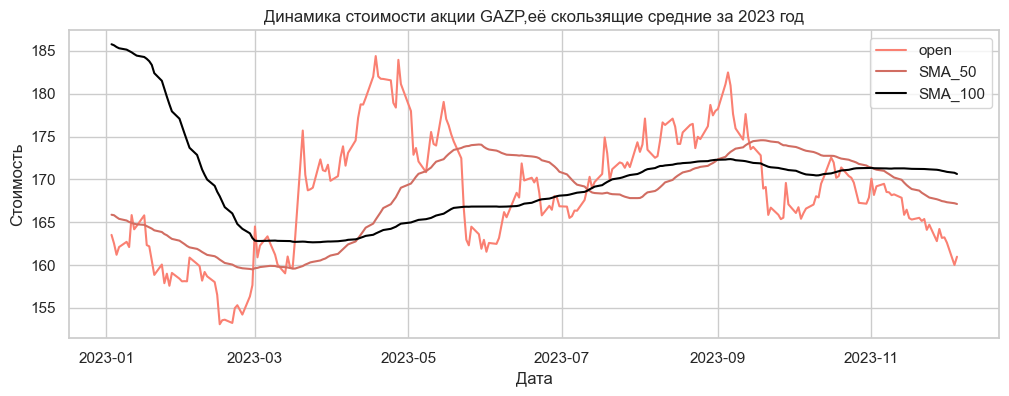

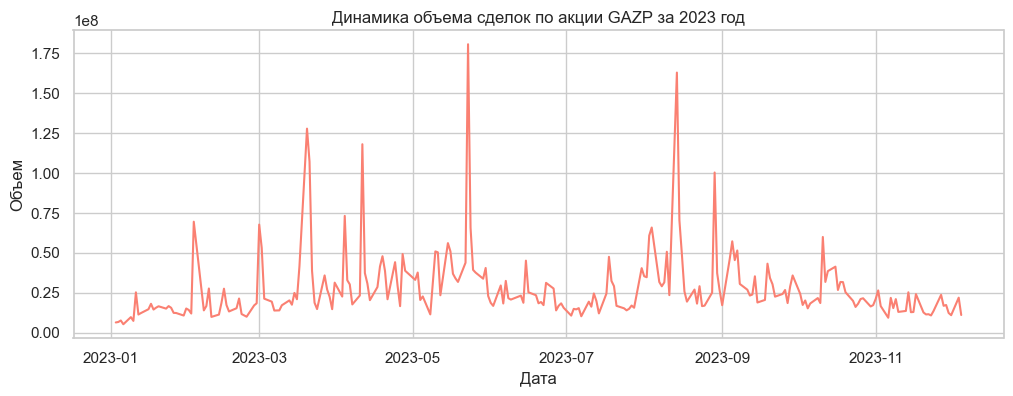

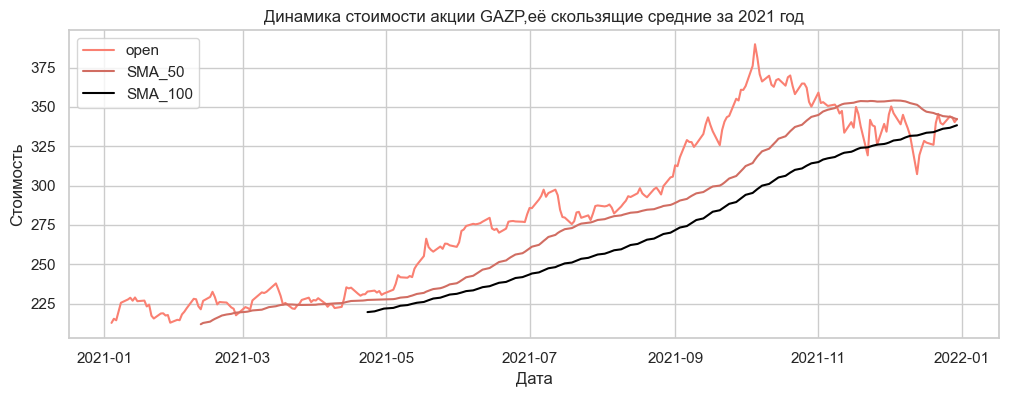

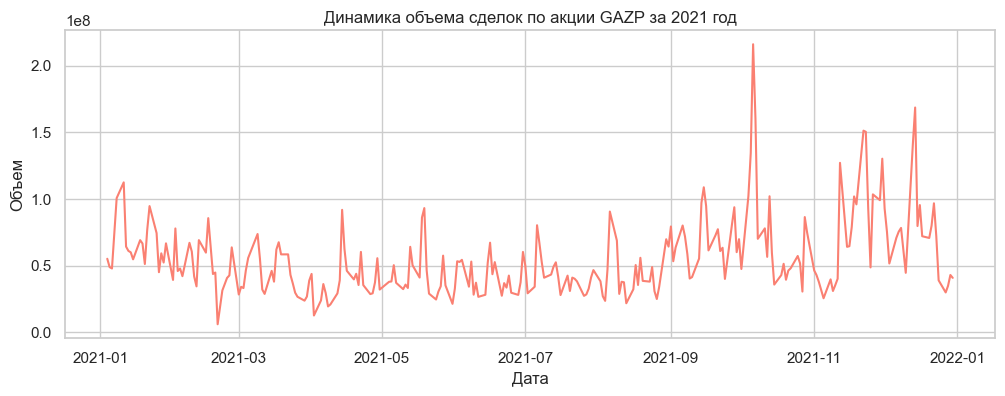

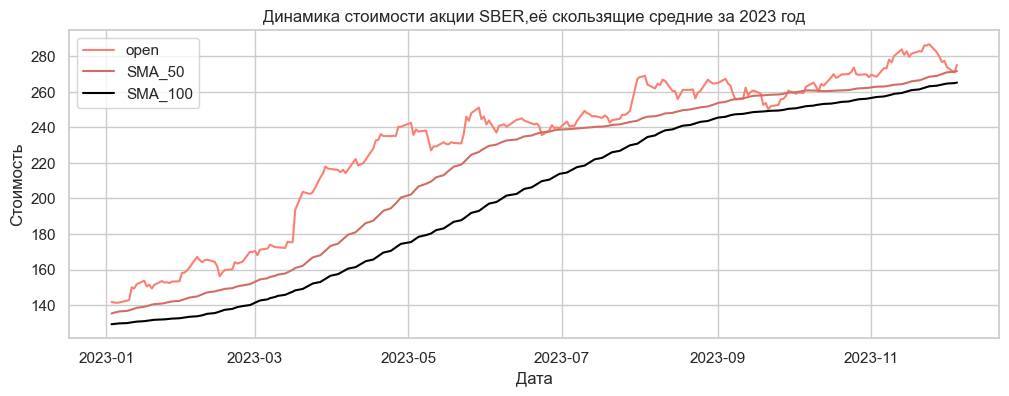

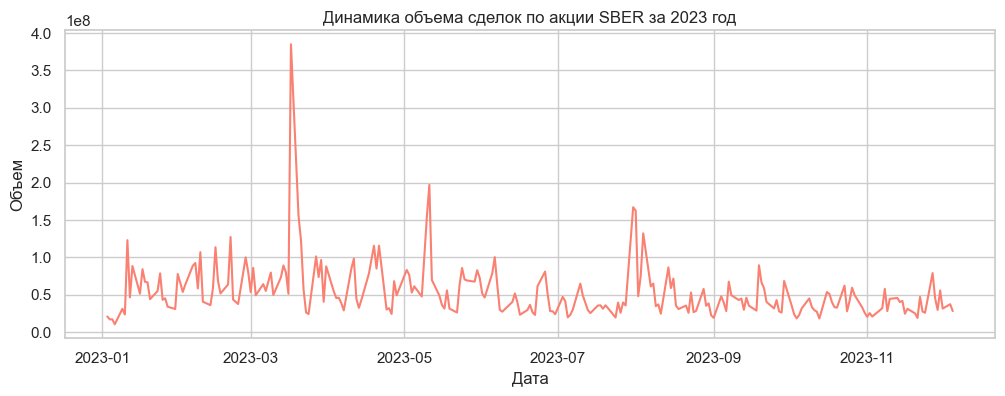

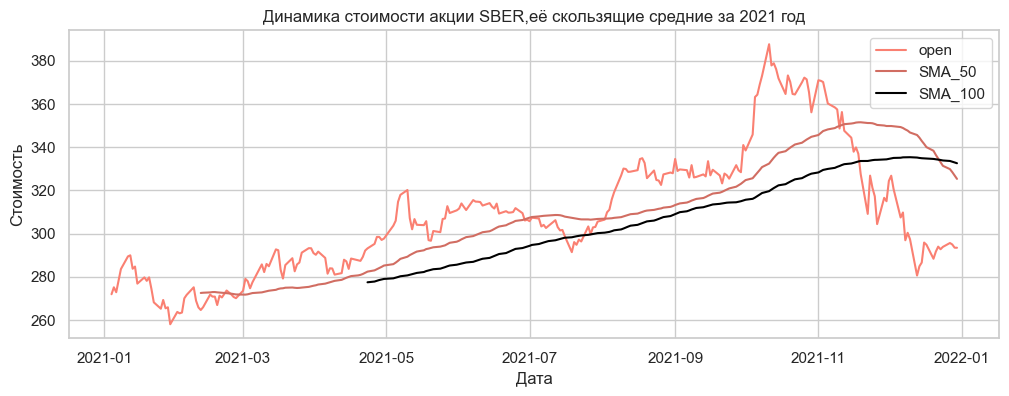

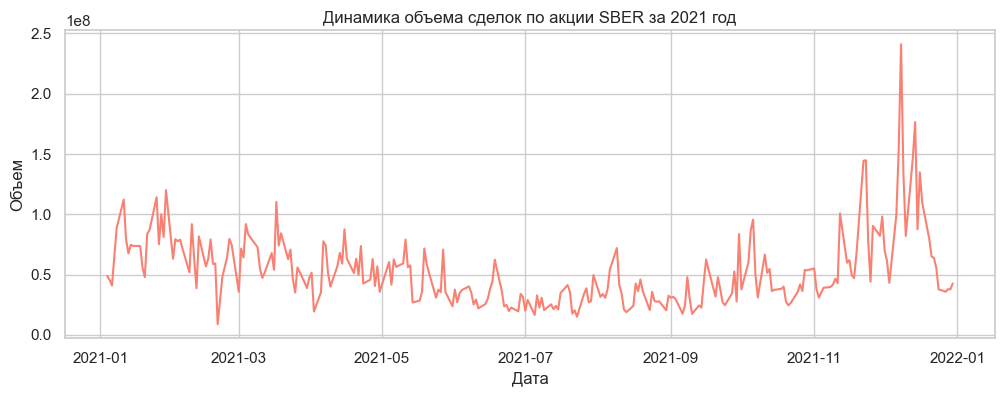

In [19]:
#введем функцию, которая рисут график цены со скользящим средним и график объема торгов
def paint_graphs(tickers, years):
    for i in tickers: 
        for j in years:
            a = sns.lineplot(data=df[(df['ticker'] == i) & (df['year'] == j)], x='date', y='close').set(title=f'Динамика стоимости акции {i},её скользящие средние за {j} год', xlabel='Дата', ylabel='Стоимость')
            b = sns.lineplot(data=df[(df['ticker'] == i) & (df['SMA_50'] != 0) & (df['year'] == j)], x='date', y='SMA_50')
            c = sns.lineplot(data=df[(df['ticker'] == i) & (df['SMA_100'] != 0) & (df['year'] == j)], x='date', y='SMA_100', color='black')
            plt.legend(['open', 'SMA_50', 'SMA_100'])
            plt.show()
            sns.lineplot(data=df[(df['ticker'] == i) & (df['year'] == j)], x='date', y='vol').set(title=f'Динамика объема сделок по акции {i} за {j} год', xlabel='Дата', ylabel='Объем')
            plt.show()
    
tickers = ['GAZP', 'SBER']
years = ['2023', '2021']
paint_graphs(tickers, years)

Теперь график динамики стоиомости акций располагается прямо над динамикой объема сделок по этому тикеру. Я заметила общую тенденцию для всех тикеров: чаще всего при резком снижении и росте стоимости акций также резко возрастает объем сделок с этими ценными бумагами, это логично, потому что рост стоимости побуждает инвесторов продавать свои активы для получения прибыли, а снижение - пополнять порфель новыми бумагами или корректировать его доходность при существующей отрицательной доходности. Либо же, наоборот, такая активность среди инвесторов, заметивших значительное изменение динамики, порождает еще большее резкое колебание цен акций за день. <br>

Для анализа ситуации на рынке аналитики также смотрят на пересечение скользящих средних за разные периоды.  <br>

Золотой крест: Если SMA_50 снизу-вверх пересекает SMA_100, то стоит покупать акции, потому что тенденция имеет положительную динамику. На акции газпрома этот крест мы видим в конце апреля  и сентябре 2023 года. В этот период и происходит резкий рост стоимости акций газпрома. <br>

Мертвый крест: Если SMA_50 сверху-вниз пересекает SMA_100, то стоит продавать акции, потому что тенденция имеет отрицательную динамику. На акции газпрома этот крест мы видим в июле и октябре 2023 года. В этот период и происходит снижение стоимости акций газпрома. <br>


# 9. Добавьте экспоненциальные скользящие средние для каждого тикера с периодом 50.

In [20]:
b = []
ema = []
list_1 = list(df['ticker'].unique())
for i in list_1:
    k = df[df['ticker'] == i]['close'].ewm(span=50, adjust= False).mean()
    b.append(k)
for i in range(len(b)):
    ema += list(b[i])
df['EMA'] = ema
df

ticker period       date  time      open       high       low      close  \
0      AFLT      D 2020-12-01     0  72.02000  72.420000  71.46000  72.180000   
1      AFLT      D 2020-12-02     0  72.04000  72.500000  71.70000  72.500000   
2      AFLT      D 2020-12-03     0  72.28000  74.320000  72.24000  74.000000   
3      AFLT      D 2020-12-04     0  74.18000  75.480000  73.34000  74.140000   
4      AFLT      D 2020-12-07     0  74.22000  75.120000  73.60000  74.000000   
...     ...    ...        ...   ...       ...        ...       ...        ...   
4477   VTBR      D 2023-11-29     0   0.02415   0.024295   0.02386   0.023900   
4478   VTBR      D 2023-11-30     0   0.02389   0.023950   0.02350   0.023885   
4479   VTBR      D 2023-12-01     0   0.02387   0.024125   0.02352   0.023610   
4480   VTBR      D 2023-12-04     0   0.02359   0.023590   0.02247   0.022545   
4481   VTBR      D 2023-12-05     0   0.02266   0.022830   0.02233   0.022520   

               vol  volatility    SMA_10    SMA_50   SMA_100  year        EMA  
0         18609590    0.160000  0.000000  0.000000  0.000000  2020  72.180000  
1         15799530    0.460000  0.000000  0.000000  0.000000  2020  72.192549  
2         34225620    1.720000  0.000000  0.000000  0.000000  2020  72.263429  
3         36921900   -0.040000  0.000000  0.000000  0.000000  2020  72.337020  
4         25660380   -0.220000  0.000000  0.000000  0.000000  2020  72.402235  
...            ...         ...       ...       ...       ...   ...        ...  
4477   43809670000   -0.000250  0.024472  0.025176  0.025798  2023   0.025145  
4478   72907910000   -0.000005  0.024445  0.025161  0.025806  2023   0.025096  
4479   60649830000   -0.000260  0.024368  0.025131  0.025809  2023   0.025037  
4480  110411120000   -0.001045  0.024181  0.025080  0.025802  2023   0.024940  
4481   71031210000   -0.000140  0.023984  0.025020  0.025792  2023   0.024845  

[4482 rows x 15 columns]

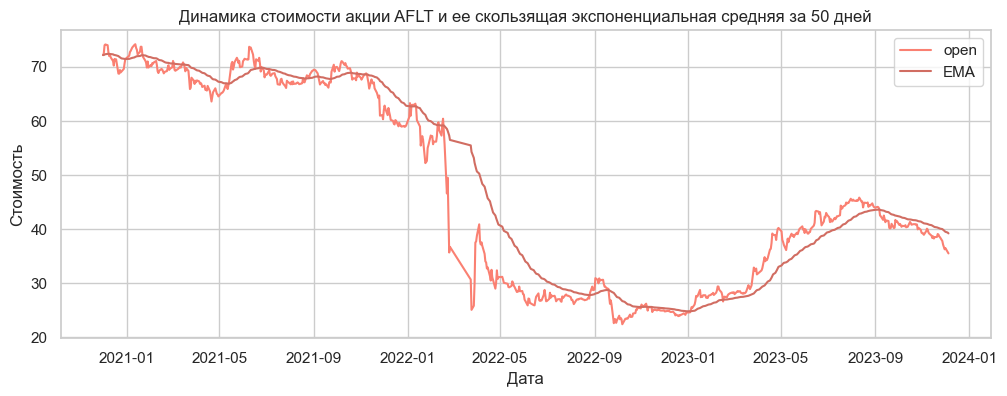

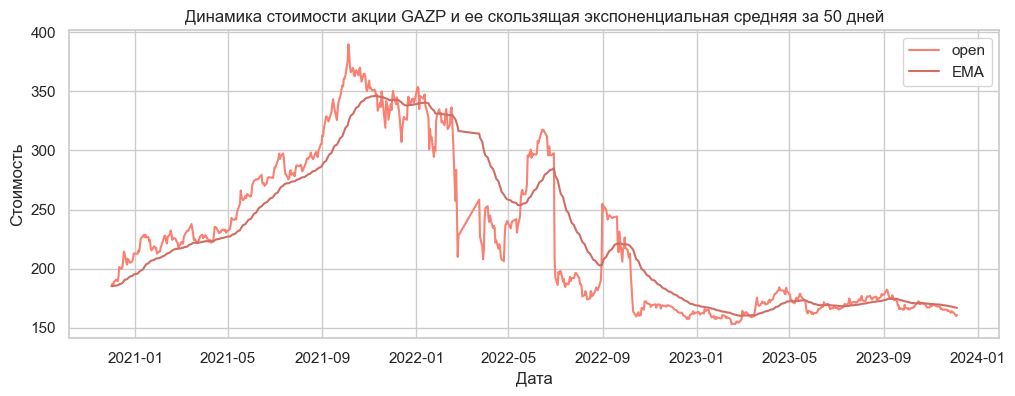

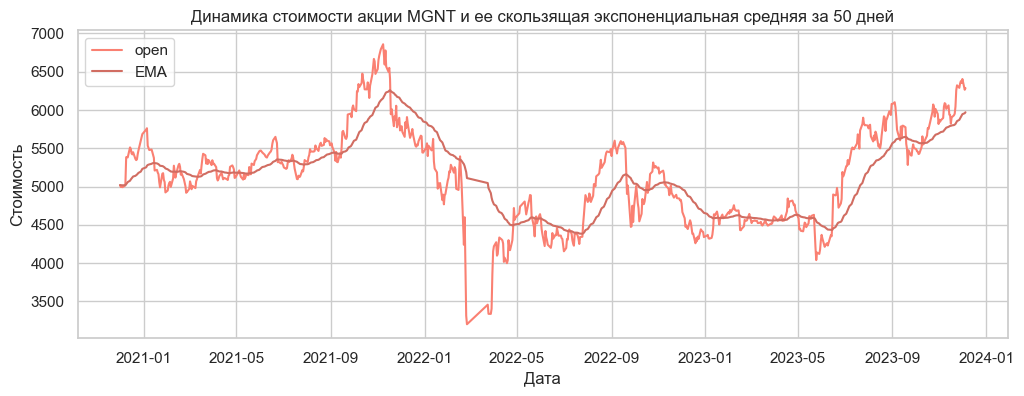

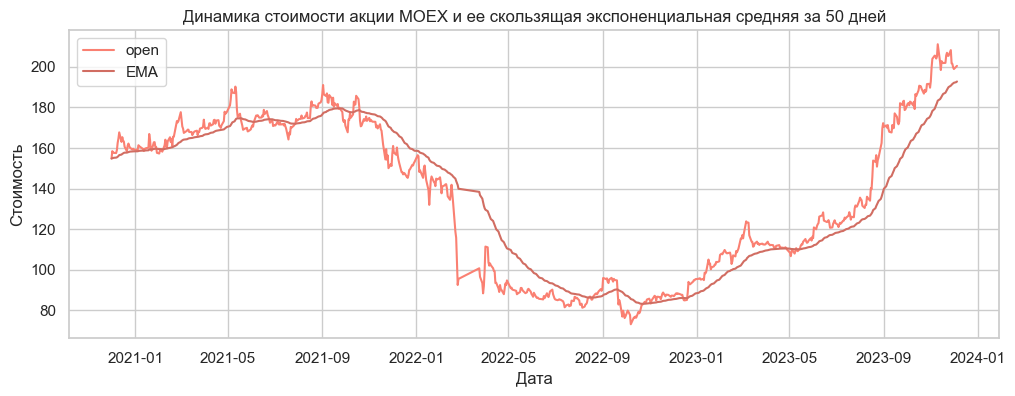

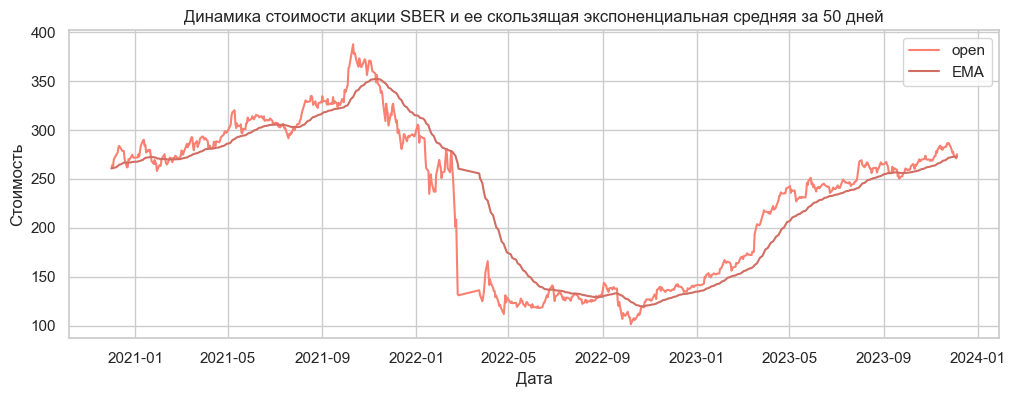

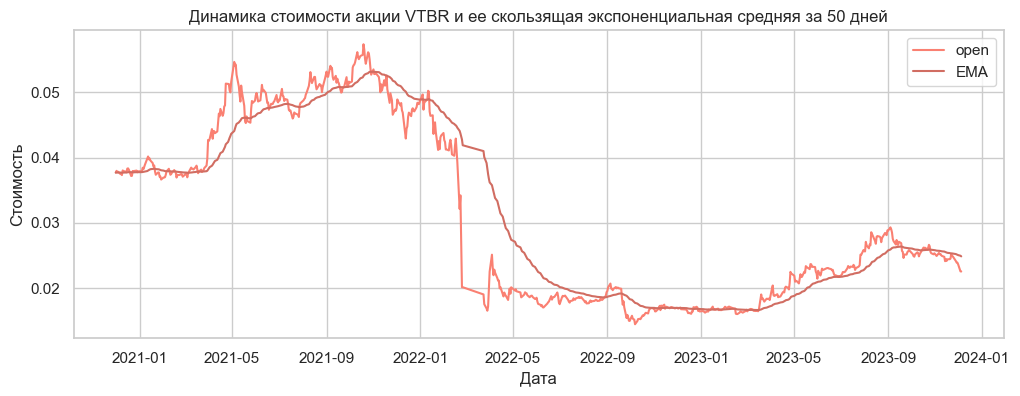

In [21]:
list_1 = list(df['ticker'].unique())
for i in list_1:
    a = sns.lineplot(data=df[df['ticker'] == i], x='date', y='close').set(title=f'Динамика стоимости акции {i} и ее скользящая экспоненциальная средняя за 50 дней', xlabel='Дата', ylabel='Стоимость')
    b = sns.lineplot(data=df[df['ticker'] == i], x='date', y='EMA')
    plt.legend(['open', 'EMA'])
    plt.show(a, b)

В отличие от метода скользящих средних, экспоненциальное сглаживание работает куда лучше, при пятидесятидневном интервале сглаживания график среднего повторяет общую динамку стоимости акции, причем учитывает мелкие колебания, которые были незаметны на графике обычной сглаженной средней, поэтому общая линия тренда выглядит более резкой и в некоторых местах несколько ломаной. 
Однако, при экспоненциальном сглаживании не учитываются тренд и сезонные колебания, что является недостатком этого метода. <br>

<br>
Кроме того, ЕМА_50 тоже используют в качестве сигналов к продаже или покупке, как и обычные скользящие средние.  Когда цена выше линии - покупка, когда ниже - продажа. 

# 10. Осуществите расчет индикатора RSI.

In [24]:
e = []
rsi = []
list_1 = list(df['ticker'].unique())
for i in list_1:
    delta = df[df['ticker'] == i]['close'].diff() #разница между текущей и предыдущей ценой закрытия
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean() #считаем по сглаженной средней за 14 периодов, в которых разница закрытия больше 0 и заменят остальные на 0, если усл не вып - зеленые свечи
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean() #считаем по сглаженной средней за 14 периодов, в которых разница закрытия меньше 0 и заменят остальные на 0, если усл не вып - красные свечи
    rs = gain / loss #сумма зеленых свечей / сумма красных
    k = 100 - (100 / (1 + rs)).fillna(0)
    e.append(k)
for i in range(len(e)):
    rsi += list(e[i])
df['RSI'] = rsi
df

ticker period       date  time      open       high       low      close  \
0      AFLT      D 2020-12-01     0  72.02000  72.420000  71.46000  72.180000   
1      AFLT      D 2020-12-02     0  72.04000  72.500000  71.70000  72.500000   
2      AFLT      D 2020-12-03     0  72.28000  74.320000  72.24000  74.000000   
3      AFLT      D 2020-12-04     0  74.18000  75.480000  73.34000  74.140000   
4      AFLT      D 2020-12-07     0  74.22000  75.120000  73.60000  74.000000   
...     ...    ...        ...   ...       ...        ...       ...        ...   
4477   VTBR      D 2023-11-29     0   0.02415   0.024295   0.02386   0.023900   
4478   VTBR      D 2023-11-30     0   0.02389   0.023950   0.02350   0.023885   
4479   VTBR      D 2023-12-01     0   0.02387   0.024125   0.02352   0.023610   
4480   VTBR      D 2023-12-04     0   0.02359   0.023590   0.02247   0.022545   
4481   VTBR      D 2023-12-05     0   0.02266   0.022830   0.02233   0.022520   

               vol  volatility    SMA_10    SMA_50   SMA_100  year        EMA  \
0         18609590    0.160000  0.000000  0.000000  0.000000  2020  72.180000   
1         15799530    0.460000  0.000000  0.000000  0.000000  2020  72.192549   
2         34225620    1.720000  0.000000  0.000000  0.000000  2020  72.263429   
3         36921900   -0.040000  0.000000  0.000000  0.000000  2020  72.337020   
4         25660380   -0.220000  0.000000  0.000000  0.000000  2020  72.402235   
...            ...         ...       ...       ...       ...   ...        ...   
4477   43809670000   -0.000250  0.024472  0.025176  0.025798  2023   0.025145   
4478   72907910000   -0.000005  0.024445  0.025161  0.025806  2023   0.025096   
4479   60649830000   -0.000260  0.024368  0.025131  0.025809  2023   0.025037   
4480  110411120000   -0.001045  0.024181  0.025080  0.025802  2023   0.024940   
4481   71031210000   -0.000140  0.023984  0.025020  0.025792  2023   0.024845   

             RSI  
0     100.000000  
1     100.000000  
2     100.000000  
3     100.000000  
4     100.000000  
...          ...  
4477   35.705045  
4478   36.507937  
4479   35.159236  
4480   31.944444  
4481   26.151930  

[4482 rows x 16 columns]

Данный индикатор отображает скорость и амплитуду, с которой изменяется движение цены. Его значения варьируются от 0 до 100: чем больше суммарная длина зеленых свечей, тем ближе значение индикатора к 100; чем больше суммарная длина красных свечей за определенный период - тем ближе значение индикатора к 0
Эта величина позволяет оценить, покупатели или продавцы сильнее влияли на цену в выбранном периоде и предположить дальнейшее развитие событий.

Отличия рассчета этого идекса двумя способами (второй считает библиотека pandas_pta) заключается в том, что библиотека автоматически ставит нули первым четырнадцати дням, а ручной рассчет дает нам 100 процентов. Кроме того, в функцию зашиты другие способы округления и вычисления, поэтому значения двух этих идексов могут разниться. Но я решила остановиться на идексе, который рассчитала сама. В следующих графиках я рассмотрю поведение RSI и возможные состояния рынка акций, о которых он может предвещать. 

# 11. Создайте функцию для вывода графиков: цены, скользящей средней (тип и период определите самостоятельно) и отдельный график для RSI индикатора. На графике с RSI добавьте две красные линии на уровнях 70 и 30. На вход функция принимает два параметра: тикер и год.

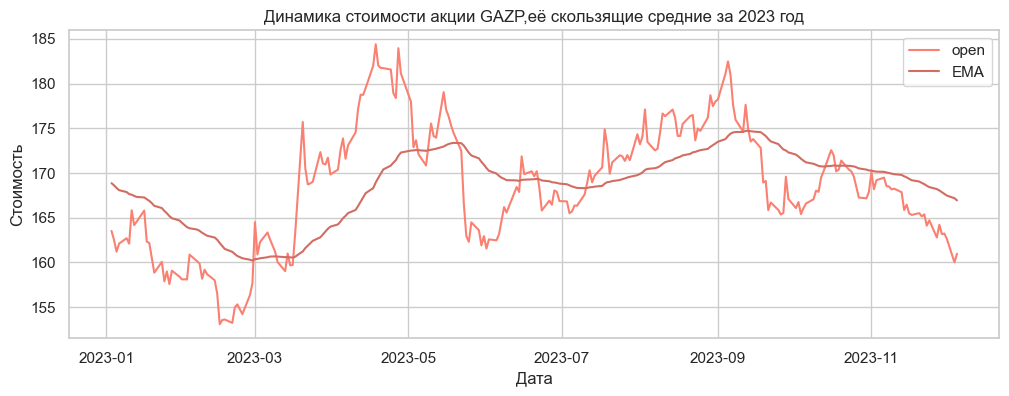

ValueError: Could not interpret value `RSI` for parameter `y`

In [22]:
def paint_graphs(tickers, years):
    for i in tickers: 
        for j in years:
            a = sns.lineplot(data=df[(df['ticker'] == i) & (df['year'] == j)], x='date', y='close').set(title=f'Динамика стоимости акции {i},её скользящие средние за {j} год', xlabel='Дата', ylabel='Стоимость')
            b = sns.lineplot(data=df[(df['ticker'] == i) & (df['EMA'] != 0) & (df['year'] == j)], x='date', y='EMA')
            plt.legend(['open', 'EMA'])
            plt.show()
            sns.lineplot(data=df[(df['ticker'] == i) & (df['year'] == j)], x='date', y='RSI').set(title=f'RSI по акции {i} за {j} год', xlabel='Дата', ylabel='Объем')
            plt.axhline(y=30, color='black', linestyle='-')
            plt.axhline(y=50, color='black', linestyle='-')
            plt.axhline(y=70, color='black', linestyle='-')
            plt.legend(['RSI'])
            plt.show()
    
tickers = ['GAZP', 'SBER']
years = ['2023', '2021']
paint_graphs(tickers, years)

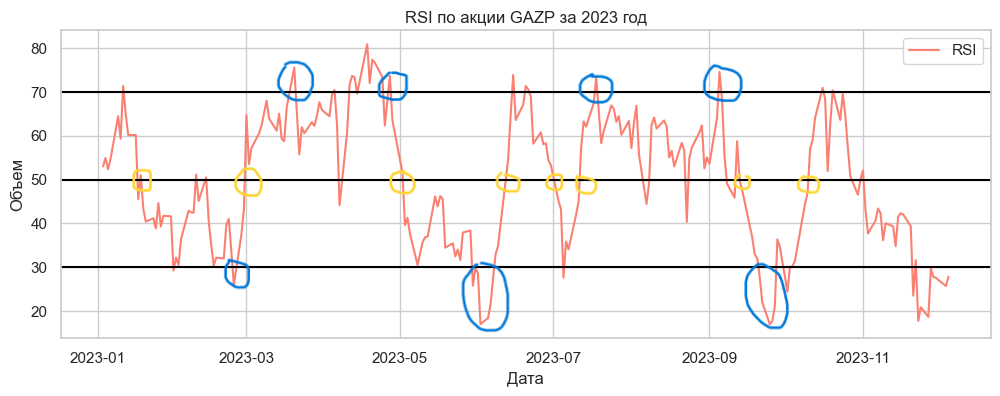

Линии уровня (30, 50, 70) я решила нарисовать не красными, а черными для того, чтобы не рябило глаз при расммотении графиков динамики лососевого цвета. <br>

Для наглядного примера я рассмотрю график динамики стоимости акций и график индекса RSI для Газпрома за 2023 год. <br>

Линия индикатора RSI колеблется от 0 до 100, однако еще очень важными являются уровни в 30 и 70. Так как: если значение RSI 70 и выше - актив перекуплен и входить в покупки сейчас неблагоразумно, если значение индикатора  ниже 30 - актив перепродан и вы рискуете продать его на дне, хороший момент для покупки актива. Однако такое четкое правило редко работает, поэтому вывод или вход ы актив ищут по тому времени, когда индикатор пересекает 30 и 70 сверху вниз, либо снизу вверх. <br>

То есть, например, если мы смотрим на уровень 30 (зона перепроданности), то покупать акцию Газпрома самым удачным образом следовало в конце февраля, начале июня и в начале октября, когда график RSI вторично пересекал уровень 30 уже в поднимающемся после падения тренде. Если говорить о зоне перекупленности (70), то продать акции можно было в начале апреля, мая, сентября. <br>

Также считают, что если значение индикатора пересекает отметку в 50 - то тренд меняется.  Для убеждения в восхождении тренда можно дождаться пока RSI пересечет отметку в 50, для нисходящей тенденции нужно ждать,  пока RSI опустится ниже значения 50. Желтые кружочки - моменты пересечения RSI действительно показывают нам резкое изменение тенденции, которая обращается либо в резкий рост, либо в падение. И, действительно, такие пересечения полностью коррелируют с общей динамикой стоимости акций (например, в марте 2023 RSI пересек вверх уровень 50, и стоимость акций в этот период относительно других резко выросла, в мае же 2023 RSI пересек уровень 50 вниз и цена акций за этот период резко сменила свой тренд в отрицательную сторону.  <br>

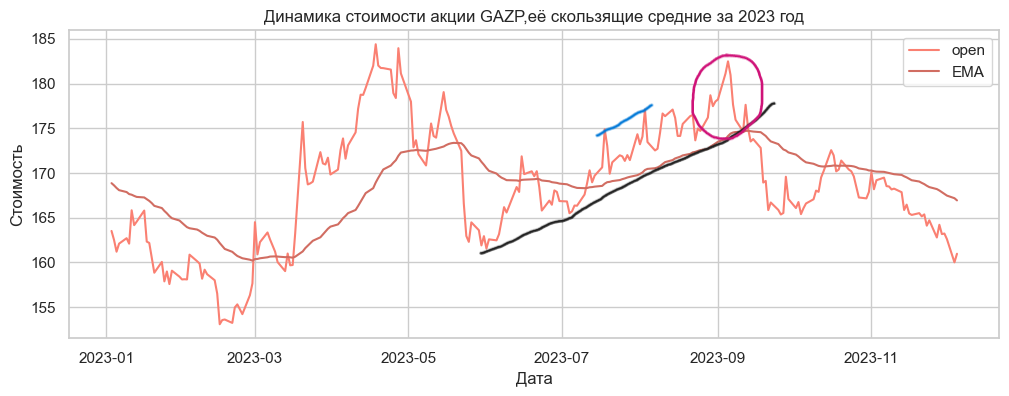

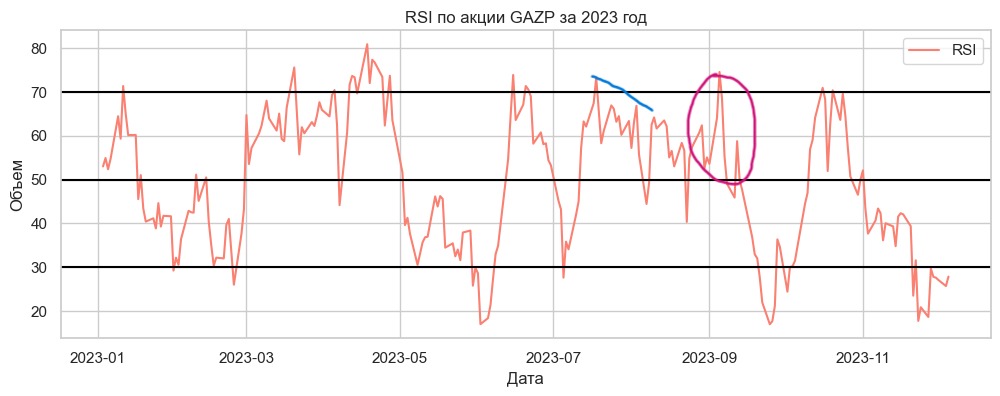

Кроме того, график идекса RSI часто используют для поиска графических фигур, которые могут знаменовать предстоящее изменение движения цены (замедление или ускорение). Рассмотрим некоторые из таких фигур на акциях Газпрома за 2023 год. <br>

Самым распространенным сигналом. Если цена делает два возрастающих максимума на вершине тренда, а индикатор RSI демонстрирует их снижение, это явный признак, что рост цены замедляется и новый максимум сформировался за счет отсутствия продавцов. В такой ситуации стоит воздержаться от новых покупок, поискать оптимальные цены для закрытия текущих длинных позиций. Такое мы можем заметить в период с июиля по сентябрь 2023 года, а потом на короткий период акция проседает вниз, падая в стоимости. <br>

Особенно надежными сигналами можно считать те, которые появляются одновременно на графике индикатора и на графике цены, фигуру голова и плечи мы можем увидеть в сентябре 2023 года, она показывает нам разворот тренда, который действительно сменяет рост резким падением. 


# 12. Постройте модель прогноза цены акции.

Я буду пытаться построить прогноз цены закрытия акций Сбербанка за 2022 год с помощью линейной регрессии. В интернет источниках пишут, что в качестве еще одного фактора стоит взять процентное изменение цены закрытия по сравнению с предыдущим периодом. 

In [23]:
df['change'] = df['close'].pct_change().fillna(0)  #процентное изменение цены закрытия по сравнению с предыдущим днем

In [24]:
#выберем то, что будем прогнозировать
good_df = df[(df['year'] == '2022') & (df['ticker'] == 'SBER')]

In [25]:
#посчитаем корреляцию
good_df.corr(method='kendall')['close']

time               NaN
open          0.825215
high          0.878548
low           0.881986
close         1.000000
vol           0.223792
volatility    0.048948
SMA_10        0.689548
SMA_50        0.260447
SMA_100       0.246432
EMA           0.304650
change        0.058773
Name: close, dtype: float64

In [26]:
# раздяем данные на признаки
x = good_df[['open', 'high', 'low', 'vol', 'volatility', 'change', 'SMA_10']]
y = good_df['close']

In [27]:
#разделяем данные на обучающую и валидационную выборку с random_state=13
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13) 

In [28]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)

In [29]:
# Используем «стандартизатор» для тестовой выборки
x_test_st = scaler.transform(x_test)

In [30]:
# создадим модель линейной регрессии
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
 
# создадим объект этого класса и запишем в переменную model
model_1 = Lasso()

# обучим нашу модель
model_1.fit(x_train_st, y_train)

# напечатаем коэффициенты
print(model_1.coef_, model_1.intercept_)

[ 0.         23.15484519 28.69177528  0.          1.2780628   0.30374675
  0.        ] 151.91149732620318


In [31]:
# делаем прогнозы
predictions = model_1.predict(x_test_st)

In [32]:
# проверяем r2
from sklearn.metrics import  mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
r2_score(y_test,predictions)

0.9949441160839465

C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\3992461598.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')


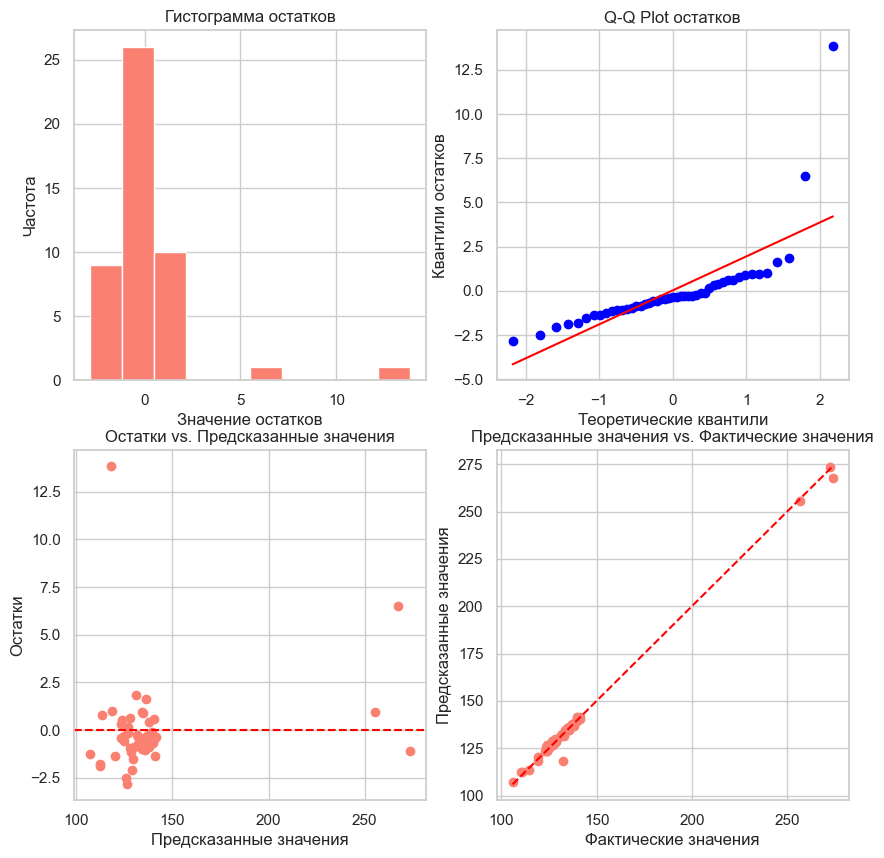

In [33]:
import statsmodels.api as sm

# Получение остатков модели
residuals = y_test - predictions

# Расчет стандартизированных остатков
stand_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
plt.subplots(figsize=(10, 10))


# Распределение остатков
plt.subplot(2, 2, 1)
plt.hist(residuals)
plt.xlabel('Значение остатков')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)


# График остатков vs. предсказанных значений
plt.subplot(2, 2, 2)
st.probplot(residuals, dist='norm', plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили остатков')
plt.title('Q-Q Plot остатков')
plt.grid(True)

#График остатков относительно прогноза
plt.subplot(2, 2, 3)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs. Предсказанные значения')

# Предсказанные и фактические значения
plt.subplot(2, 2, 4)
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения vs. Фактические значения')
plt.show()

In [34]:
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

In [35]:
print("Среднеквадратическая ошибка (MSE):", mse)
print("Среднеквадратическая ошибка (RMSE):", rmse)
print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя абсолютная ошибка  (MAPE):", mape)

Среднеквадратическая ошибка (MSE): 6.127879525822308
Среднеквадратическая ошибка (RMSE): 2.475455417861996
Средняя абсолютная ошибка (MAE): 1.2932655286648609
Средняя абсолютная ошибка  (MAPE): 0.009357001164112281


Как мы можем заметить, коэффициент детерминации практичски равен единице из-за сильной гетероскедастичности остатков в данной модели. Предсказаннные значения хорошо ложаться на линию регресии, но мне кажется, что данных в тестовой выборке маловато для утверждения о том, что модель хорошо попала в значения. Кроме того, остатки, очевидно, распределены ненормально и имееют несколько хорошо выделяющихся выбросов. <br>
Чтобы расширить количество данных в тестовой выборке, я применю только что построенную модель ко всему массиву данных за 2021 год у Сбербанка, и посмотрю как ведут себя там предсказанные значению по отношению к фактическим. 

In [37]:
#обучим модель на все данные close
alll = x
alll_t= scaler.fit_transform(alll)
predict = model_1.predict(alll_t)

In [38]:
df_1 = pd.DataFrame({'close': list(good_df['close']), 'predictions': predict})
df_1

close  predictions
0    305.47   310.569067
1    304.24   314.651985
2    287.01   300.180970
3    293.92   297.418844
4    291.69   301.454263
..      ...          ...
229  140.95   142.837760
230  139.90   143.287670
231  139.51   142.219434
232  140.96   143.559456
233  141.15   143.748667

[234 rows x 2 columns]

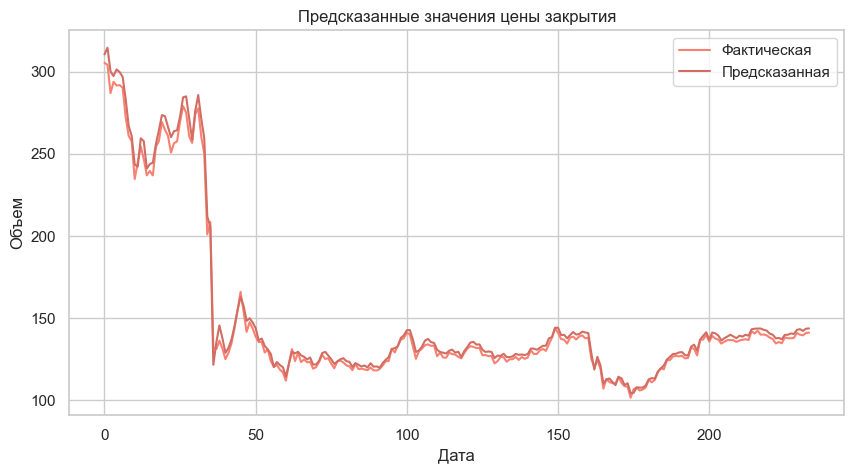

In [44]:
plt.figure(figsize=(10, 5)) 
sns.lineplot(data=df_1['close']).set(title=f'Фактические значения цены закрытия', xlabel='Дата', ylabel='Объем')
sns.lineplot(data=df_1['predictions']).set(title=f'Предсказанные значения цены закрытия', xlabel='Дата', ylabel='Объем')
plt.legend(('Фактическая', 'Предсказанная'))
plt.show()

In [40]:
y_test = df_1['close']
predictions = df_1['predictions']

C:\Users\Настя\AppData\Local\Temp\ipykernel_53496\3992461598.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')


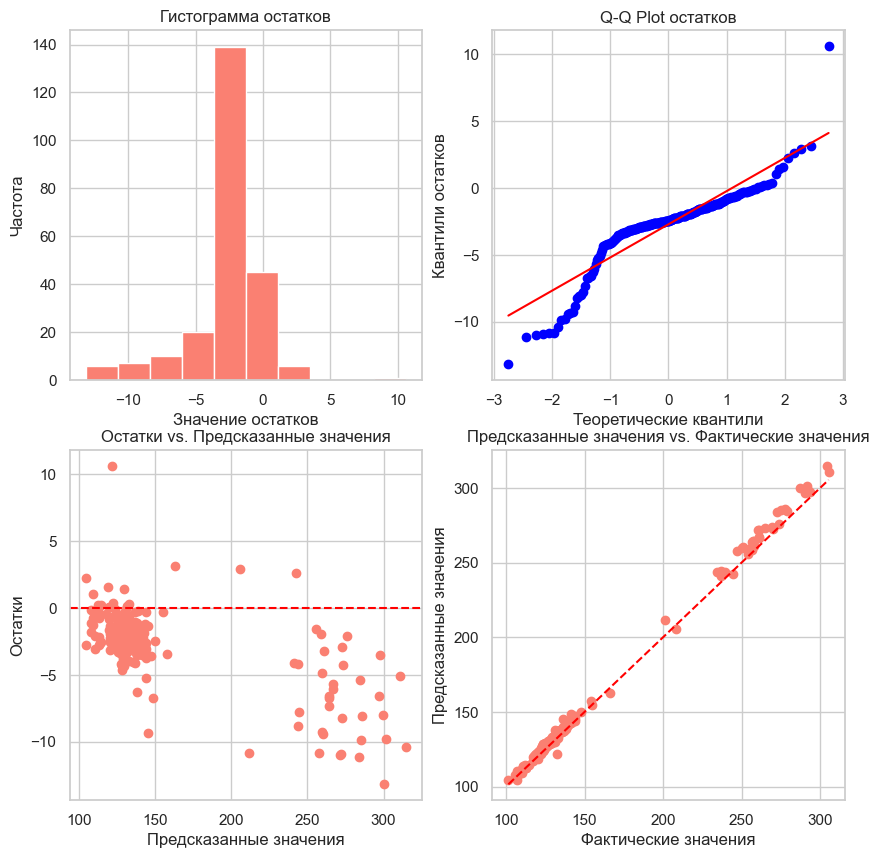

In [41]:
import statsmodels.api as sm

# Получение остатков модели
residuals = y_test - predictions

# Расчет стандартизированных остатков
stand_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
plt.subplots(figsize=(10, 10))


# Распределение остатков
plt.subplot(2, 2, 1)
plt.hist(residuals)
plt.xlabel('Значение остатков')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)


# График остатков vs. предсказанных значений
plt.subplot(2, 2, 2)
st.probplot(residuals, dist='norm', plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили остатков')
plt.title('Q-Q Plot остатков')
plt.grid(True)

#График остатков относительно прогноза
plt.subplot(2, 2, 3)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs. Предсказанные значения')

# Предсказанные и фактические значения
plt.subplot(2, 2, 4)
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения vs. Фактические значения')
plt.show()

In [42]:
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

In [43]:
print("Среднеквадратическая ошибка (MSE):", mse)
print("Среднеквадратическая ошибка (RMSE):", rmse)
print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя абсолютная ошибка  (MAPE):", mape)

Среднеквадратическая ошибка (MSE): 14.496418461358228
Среднеквадратическая ошибка (RMSE): 3.8074162448251214
Средняя абсолютная ошибка (MAE): 2.937401636464005
Средняя абсолютная ошибка  (MAPE): 0.018650798921809326


Как можно заметить, обучение всей выборки порождает увеличение ошибок прогноза, несмотря на то, что график прогноза повторяет общую динамику фактических значений и предсказанные значения лежат очень близко к линии регрессии, но у нас сохрняется гетероскедастичноть остатков и ненормальность их распределения. 